In [1]:
# General
import sys
import os
import os.path as op
import glob
from copy import deepcopy
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import warnings
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import xarray
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
from scipy import signal
from scipy.io import loadmat
import h5py

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Neuro
import mne
from fooof import FOOOF, FOOOFGroup
from fooof.objs.utils import combine_fooofs

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
from formatting import *
from helper_funcs import *
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, eeg_preproc, events_preproc, events_proc
from phase_locking import eeg_preproc, spectral_analysis, unit_lfp_comparison

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ptsa/data/TimeSeriesX.py:7: DeprecationWarning: importing from ptsa.data.TimeSeries is deprecated; import from ptsa.data.timeseries instead
  DeprecationWarning)


In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join('/data7', 'goldmine', 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


# File renaming

In [ ]:
# Rename ROIs whose labels changed.
timer = Timer()

rename_rois = {'U518_ses0-LTPO': 'U518_ses0-LmOCC',
               'U518_ses0-RTO': 'U518_ses0-RPHG',
               'U518_ses1-LTPO': 'U518_ses1-LmOCC',
               'U518_ses1-RTO': 'U518_ses1-RPHG',
               'U526_ses0-LMFG': 'U526_ses0-LAC',
               'U530_ses0-LPI_SMG': 'U530_ses0-LPI',
               'U530_ses1-LPI_SMG': 'U530_ses1-LPI',
               'U532_ses0-LFSG': 'U532_ses0-LPHG',
               'U532_ses0-RAH': 'U532_ses0-REC',
               'U540_ses0-RTP': 'U540_ses0-RPC'}
missing_files = []
renamed_files = 0
for old_name, new_name in rename_rois.items():
    top_dir = '/scratch/dscho/goldmine'
    for gs in ['delay', 'nav']:
        for sub_dirs in ['spectral/power', 'spectral/phase', 'p_episode']:
            extn = '.pkl'
            old_fpath = op.join(top_dir, gs, sub_dirs, old_name + extn)
            new_fpath = op.join(top_dir, gs, sub_dirs, new_name + extn)
            if op.exists(old_fpath):
                os.rename(old_fpath, new_fpath)
                renamed_files += 1
            else:
                missing_files.append(old_fpath)
    
    top_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine'
    for sub_dirs in ['delay/fooof', 'nav/fooof']:
        extn = '.json'
        old_fpath = op.join(top_dir, sub_dirs, old_name + extn)
        new_fpath = op.join(top_dir, sub_dirs, new_name + extn)
        if op.exists(old_fpath):
            os.rename(old_fpath, new_fpath)
            renamed_files += 1
        else:
            missing_files.append(old_fpath)

print('Renamed {} files; {} files were missing'.format(renamed_files, len(missing_files)))
print(timer)

# P-episode analysis

In [5]:
# data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab'
# # data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/delay'
# # data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'
# subj_sess = 'U530_ses0'
# roi = 'LMH'
# freqs = np.arange(1, 31)
# verbose = True

# # -----------------
# event_eeg = eeg_preproc.load_event_eeg(subj_sess, [roi], verbose=verbose)[roi].stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time')
# power = spectral_analysis.timefreq_wavelet(event_eeg, freqs, output='power', verbose=verbose)
# fooof_group = spectral_analysis.run_fooof(subj_sess, roi, verbose=verbose)

In [12]:
# Load all P-episode results.
# data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab'
# data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/delay'
# data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'
data_dir = ['/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab',
            '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav']
n_rois = 8
save_output = True
overwrite = False
verbose = True
freqs = np.arange(1, 31)

timer = Timer()

data_dir = np.atleast_1d(data_dir)
pep_pct = []
for _dir in data_dir:
    pep_pct.append(spectral_analysis.load_p_episode_pct(n_rois=n_rois,
                                                        data_dir=_dir,
                                                        save_output=save_output,
                                                        overwrite=overwrite,
                                                        verbose=verbose))
pep_pct = pd.concat(pep_pct).reset_index(drop=True)
roi_map = spike_preproc.roi_mapping(n_rois)
pep_pct['roi_gen'] = pep_pct['roi'].apply(lambda x: roi_map[x])

# Drop unwanted regions.
drop_rois = ['MC', 'PC', 'TP']
drop_idx = pep_pct.loc[np.isin(pep_pct['roi_gen'], 'Other') | np.isin(pep_pct['roi'], drop_rois)].index
pep_pct = pep_pct.drop(index=drop_idx).reset_index(drop=True)

# Reformat regions.
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC']
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']
if 'roi_gen2' in pep_pct.columns:
    pep_pct.drop(columns=['roi_gen2'], inplace=True)
pep_pct['roi_gen'] = pep_pct['roi_gen'].astype(str)
pep_pct.loc[pep_pct['roi_gen']=='CC', 'roi_gen'] = 'ACC'
pep_pct.loc[pep_pct['roi_gen']=='LTC', 'roi_gen'] = 'STG'
pep_pct['roi_gen'] = pep_pct['roi_gen'].astype(pd.CategoricalDtype(gen_rois, ordered=True))
pep_pct.insert(pep_pct.columns.tolist().index('roi_gen')+1, 'roi_gen2', '')
pep_pct.loc[np.isin(pep_pct['hemroi'].apply(lambda x: x[1:]), hpc_rois), 'roi_gen2'] = 'HPC'
pep_pct.loc[np.isin(pep_pct['hemroi'].apply(lambda x: x[1:]), mtl_rois), 'roi_gen2'] = 'MTL'
pep_pct.loc[~np.isin(pep_pct['hemroi'].apply(lambda x: x[1:]), hpc_rois + mtl_rois), 'roi_gen2'] = 'CTX'
pep_pct['roi_gen2'] = pep_pct['roi_gen2'].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

# Calculcate mean P-episode at each freq across sessions within each subject.
pep_pct_agg1 = pep_pct.groupby(['subj', 'roi_gen'], observed=True)[freqs].mean().reset_index()
pep_pct_agg2 = pep_pct.groupby(['subj', 'roi_gen2'], observed=True)[freqs].mean().reset_index()

print('pep_pct: {}'.format(pep_pct.shape))
print('pep_pct_agg1: {}'.format(pep_pct_agg1.shape))
print('pep_pct_agg2: {}'.format(pep_pct_agg2.shape))
print(timer)

pep_pct: (470, 37)
pep_pct_agg1: (124, 32)
pep_pct_agg2: (83, 32)
Ran in 0.0s


In [69]:
pep_pct.drop_duplicates(['subj', 'hemroi']).groupby('roi_gen').size()

roi_gen
HPC    53
EC     31
AMY    38
PHG    22
STG    13
OFC    26
ACC    13
dtype: int64

In [78]:
freqs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [77]:
pep_pct_agg1.iloc[]

subj roi_gen         1         2         3         4         5         6  \
0  U369     HPC  0.013120  0.035493  0.037218  0.044559  0.029787  0.036553   
1  U369     AMY  0.014920  0.037926  0.036992  0.046935  0.032251  0.037815   
2  U369     STG  0.024032  0.040684  0.022532  0.028010  0.078432  0.164689   
3  U370     HPC  0.045985  0.064673  0.047794  0.021035  0.015050  0.017701   
4  U370      EC  0.024930  0.046365  0.035737  0.023334  0.021314  0.024409   

          7         8         9        10        11        12        13  \
0  0.052409  0.048421  0.038266  0.026923  0.019328  0.014462  0.012205   
1  0.046236  0.044655  0.036479  0.028958  0.022335  0.016722  0.014450   
2  0.195818  0.156770  0.073359  0.022688  0.015563  0.014986  0.015011   
3  0.019379  0.016906  0.013117  0.011665  0.011191  0.010939  0.011011   
4  0.023755  0.020788  0.018625  0.017787  0.017674  0.017824  0.018181   

         14        15        16        17        18        19        20  \
0  0.011978  0.011581  0.011047  0.010664  0.010482  0.011071  0.011979   
1  0.014004  0.013929  0.013490  0.013089  0.012738  0.012432  0.012175   
2  0.014631  0.014537  0.013877  0.013106  0.012646  0.012230  0.011995   
3  0.011648  0.012043  0.013389  0.015355  0.017363  0.018624  0.018894   
4  0.017536  0.017111  0.016649  0.016012  0.015208  0.014452  0.013872   

         21        22        23        24        25        26        27  \
0  0.012048  0.012034  0.011751  0.011767  0.011722  0.011760  0.011618   
1  0.012002  0.012076  0.011942  0.011951  0.012088  0.012505  0.012910   
2  0.012065  0.011990  0.011695  0.011646  0.011558  0.011783  0.012174   
3  0.018472  0.017322  0.016273  0.015251  0.014271  0.013869  0.013353   
4  0.013270  0.012478  0.012072  0.011836  0.011575  0.011158  0.011020   

         28        29        30  
0  0.012061  0.012348  0.012863  
1  0.013622  0.014349  0.015046  
2  0.012861  0.013143  0.013925  
3  0.012730  0.012331  0.011936  
4  0.010905  0.011088  0.011405

In [97]:
#pep_pct_agg1[np.arange(bands['slow_theta'][0], bands['slow_theta'][1]+1)].mean(axis=1)

In [ ]:
bands.nam

In [92]:
bands.index

Index(['slow_theta', 'fast_theta', 'beta'], dtype='object')

In [106]:
dict(zip(np.arange(len(bands)), bands.index))

{0: 'slow_theta', 1: 'fast_theta', 2: 'beta'}

In [128]:
band_means.shape

(28, 3)

In [129]:
band_means.head()

slow_theta  fast_theta      beta
0     0.039090    0.040514  0.011376
3     0.044501    0.015754  0.014791
7     0.079721    0.028384  0.013715
11    0.036276    0.019398  0.016808
15    0.046539    0.018345  0.024872

In [125]:
pep_pct_agg1.query("(roi_gen=='HPC')").index

Int64Index([  0,   3,   7,  11,  15,  20,  24,  27,  31,  36,  40,  44,  50,
             52,  57,  61,  66,  71,  76,  81,  85,  89,  95, 101, 106, 112,
            115, 120],
           dtype='int64')

In [133]:
pep_pct_agg1.loc[roi_idx, 'subj'].values

array(['U369', 'U370', 'U371', 'U372', 'U373', 'U374', 'U379', 'U380',
       'U381', 'U384', 'U385', 'U387', 'U390', 'U392', 'U393', 'U394',
       'U395', 'U396', 'U518', 'U521', 'U526', 'U527', 'U530', 'U532',
       'U536', 'U537', 'U539', 'U540'], dtype=object)

In [136]:
pep_pct_agg1.loc[roi_idx, 'subj']

0      U369
3      U370
7      U371
11     U372
15     U373
20     U374
24     U379
27     U380
31     U381
36     U384
40     U385
44     U387
50     U390
52     U392
57     U393
61     U394
66     U395
71     U396
76     U518
81     U521
85     U526
89     U527
95     U530
101    U532
106    U536
112    U537
115    U539
120    U540
Name: subj, dtype: object

In [ ]:
pep_pct_agg1.reset_index()

In [137]:
band = 'slow_theta'
(pep_pct_agg1
 .loc[roi_idx, np.arange(bands[band][0], bands[band][1]+1)]
 .mean(axis=1)
 .rename(pep_pct_agg1.loc[roi_idx, 'subj']))

U369    0.039090
U370    0.044501
U371    0.079721
U372    0.036276
U373    0.046539
U374    0.045427
U379    0.028396
U380    0.040339
U381    0.026308
U384    0.037041
U385    0.034591
U387    0.038157
U390    0.040335
U392    0.049312
U393    0.050497
U394    0.097270
U395    0.081538
U396    0.067942
U518    0.154590
U521    0.050994
U526    0.078469
U527    0.056855
U530    0.077920
U532    0.057661
U536    0.049233
U537    0.022308
U539    0.045640
U540    0.022004
dtype: float64

In [155]:
# Calcuate mean P-episode across subjects,
# within a region and bands of interest.
roi = 'HPC'
bands = pd.Series(od([('slow_theta', (2, 4)),
                      ('fast_theta', (6, 10)),
                      ('beta', (13, 20))]))
# --------------------table_dir

roi_idx = pep_pct_agg1.query("(roi_gen=='HPC')").index
band_means = (pd.concat([pep_pct_agg1
                             .loc[roi_idx, np.arange(bands[band][0], bands[band][1]+1)]
                             .mean(axis=1)
                             .rename(pep_pct_agg1.loc[roi_idx, 'subj'])
                         for band in bands.index],
                        axis=1)
              .rename(columns=dict(zip(np.arange(len(bands)), bands.index)))
              .stack()              
              .reset_index()
             )
band_means.columns = ['subj', 'band', 'val']
band_means['band'] = band_means['band'].astype(pd.CategoricalDtype(bands.index, ordered=True))
band_means['val'] *= 100

print('band_means:', band_means.shape)

band_means: (84, 3)


In [158]:
# Save the output table.
save_output = 1
overwrite = 0
table_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/tables'
# ------------------------

filepath = op.join(table_dir, 'hpc_osc_pct_by_subj_and_band.csv')
if save_output:
    if overwrite or not op.exists(filepath):
        band_means.to_csv(filepath)
        print('Saved {}'.format(filepath))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/tables/hpc_osc_pct_by_subj_and_band.csv


In [154]:
band_means.groupby('band')['val'].apply(mean_sem)

band
slow_theta    5.35 ± 0.52
fast_theta    3.54 ± 0.80
beta          2.37 ± 0.32
Name: val, dtype: object

In [156]:
band_means.head()

subj        band       val
0  U369  slow_theta  3.908990
1  U369  fast_theta  4.051449
2  U369        beta  1.137587
3  U370  slow_theta  4.450097
4  U370  fast_theta  1.575359

In [74]:
pep_pct.shape, pep_pct.drop_duplicates(['subj', 'roi_gen']).shape, pep_pct_agg1.shape

((470, 37), (124, 37), (124, 32))

In [15]:
# How many electrodes in each region?
pep_pct_agg1.groupby(['roi_gen']).size()

roi_gen
HPC    28
EC     20
AMY    24
PHG    17
STG     8
OFC    19
ACC     8
dtype: int64

In [17]:
# How many electrodes in each region?
pep_pct_agg2.groupby(['roi_gen2']).size()

roi_gen2
HPC    28
MTL    27
CTX    28
dtype: int64

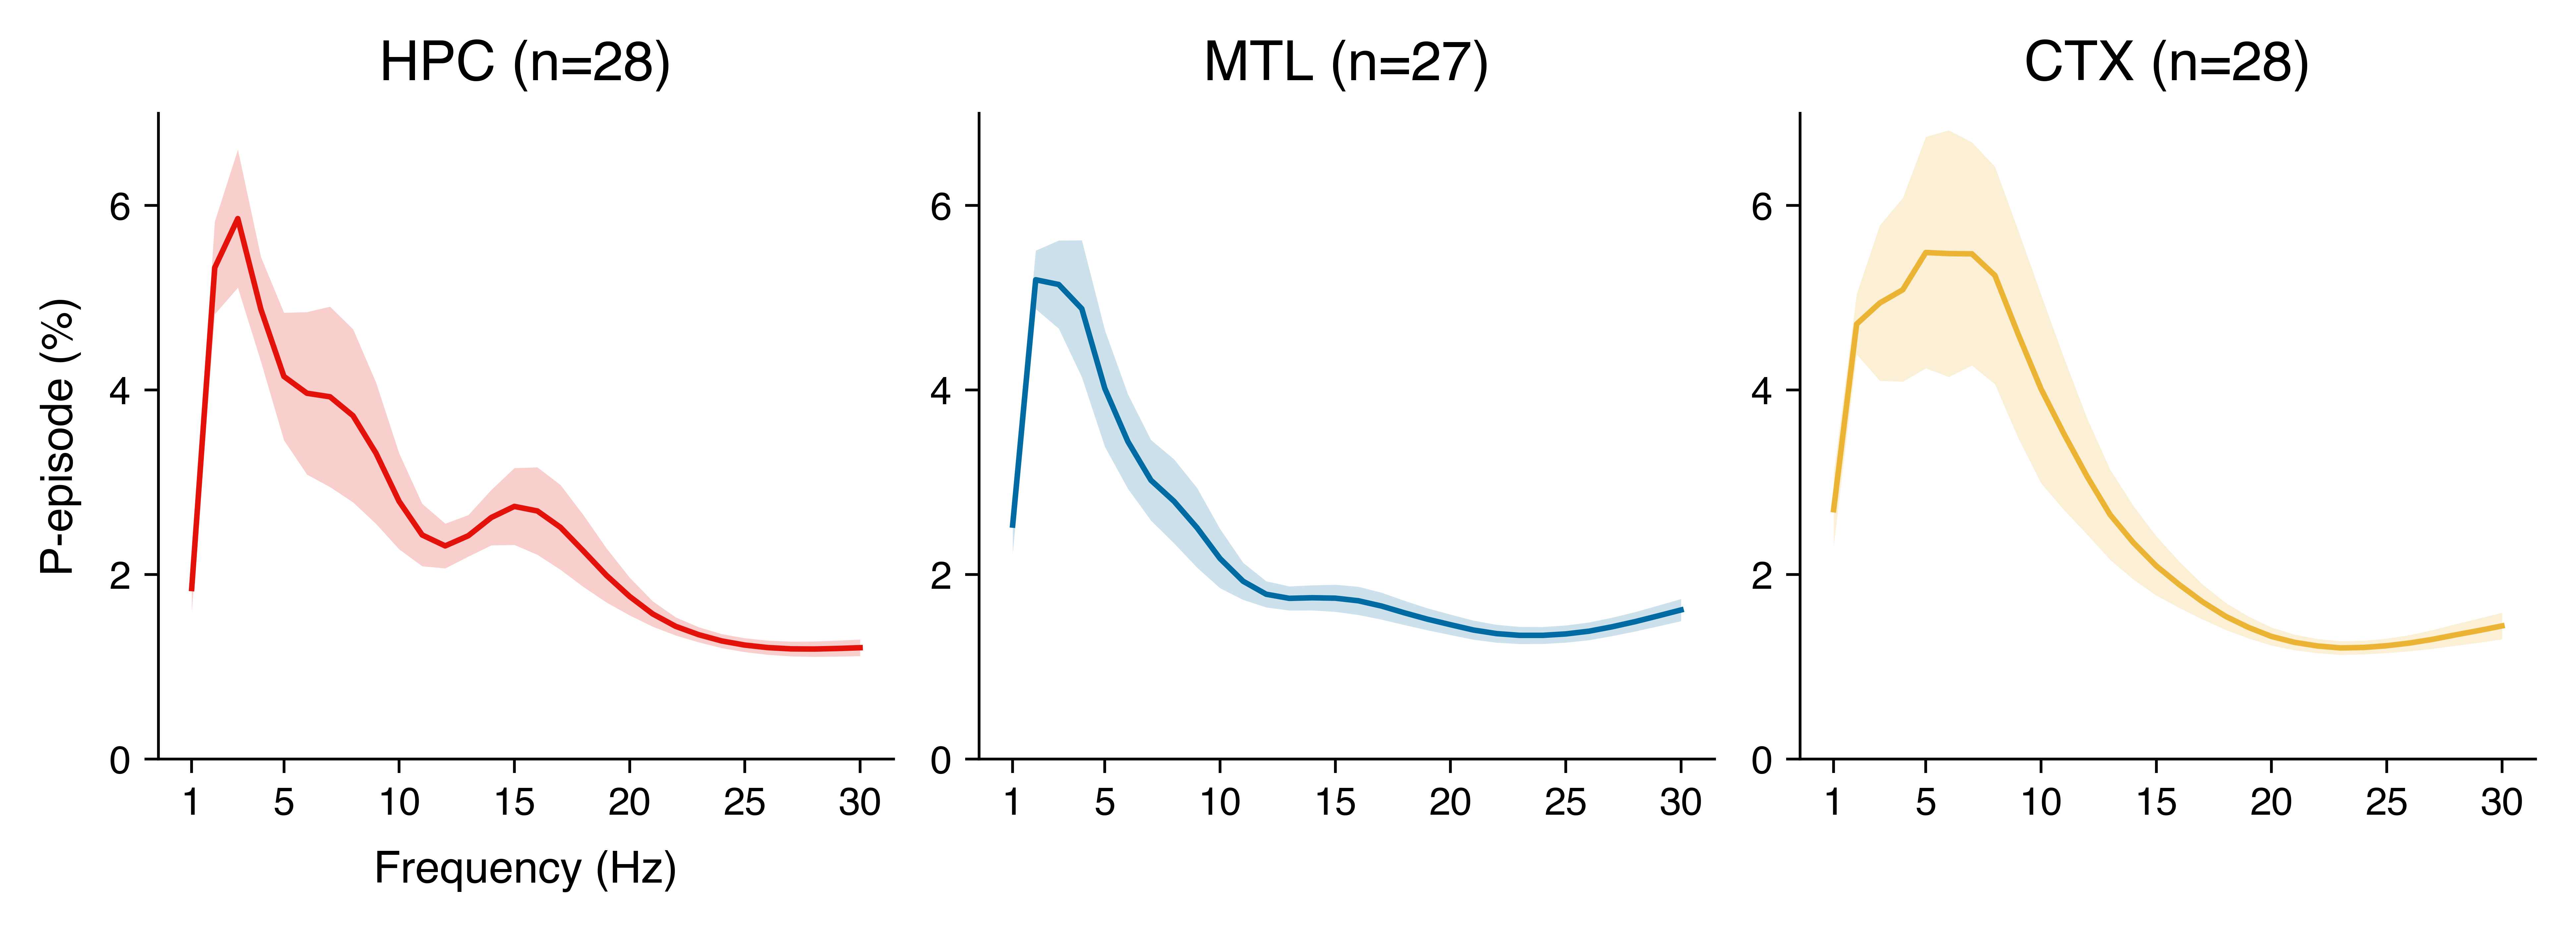

In [18]:
# Plot P-episode for each region, across electrodes for all subjects.
expmt = 'ycab-goldmine_nav'
roi_col = 'roi_gen2'
rois = ['HPC', 'MTL', 'CTX']
roi_colors = {'HPC': colors['r'],
              'MTL': colors['b'],
              'CTX': colors['y']}
roi_count = pep_pct_agg2.groupby(roi_col).size()
figsize = (colws[3], colws[3]*0.36)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
linewidth = 1
spine_lw = 0.5
labelpad = 5
tickpad = 2.5
ticklen = 2.5
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (0, 7)
yticks = [0, 2, 4, 6]
yticklabs = yticks
plot_mean = True
verbose = False
savefig = True
overwrite = False

# --------------------------------
# Get the data.
means = pep_pct_agg2.groupby(roi_col)[freqs].mean() * 100
stds = pep_pct_agg2.groupby(roi_col)[freqs].std() * 100
sems = pep_pct_agg2.groupby(roi_col)[freqs].sem() * 100
medians = pep_pct_agg2.groupby(roi_col)[freqs].median() * 100
q1 = pep_pct_agg2.groupby(roi_col)[freqs].agg({freq: lambda x: np.percentile(x, 25) * 100 for freq in freqs})
q3 = pep_pct_agg2.groupby(roi_col)[freqs].agg({freq: lambda x: np.percentile(x, 75) * 100 for freq in freqs})

# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, roi in enumerate(rois):
    _ax = ax[iax]
    if plot_mean:
        _ax.fill_between(xvals,
                         means.loc[roi].values + sems.loc[roi].values,
                         means.loc[roi].values - sems.loc[roi].values,
                         alpha=0.2, lw=0, color=roi_colors[roi])
        _ax.plot(xvals, means.loc[roi].values,
                 lw=1, color=roi_colors[roi])
    else:
        _ax.fill_between(xvals, q3.loc[roi].values, q1.loc[roi].values,
                         alpha=0.2, lw=0, color=roi_colors[roi])
        _ax.plot(xvals, medians.loc[roi].values,
                 lw=1, color=roi_colors[roi])
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    _ax.set_title('{} (n={})'.format(roi, roi_count[roi]), fontsize=font['fig'])
    if iax == 0:
        _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('P-episode (%)', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.set_xlabel('')
        _ax.set_ylabel('')
        
fig.tight_layout()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2', 
                       'p_episode-{}-{}subjs-{}hpc_{}mtl_{}ctx_elecs.pdf'
                       .format(expmt,
                               pep_pct_agg2['subj'].unique().size,
                               roi_count['HPC'],
                               roi_count['MTL'],
                               roi_count['CTX']))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [20]:
pep_pct_agg1.head()

subj roi_gen         1         2         3         4         5         6  \
0  U369     HPC  0.013120  0.035493  0.037218  0.044559  0.029787  0.036553   
1  U369     AMY  0.014920  0.037926  0.036992  0.046935  0.032251  0.037815   
2  U369     STG  0.024032  0.040684  0.022532  0.028010  0.078432  0.164689   
3  U370     HPC  0.045985  0.064673  0.047794  0.021035  0.015050  0.017701   
4  U370      EC  0.024930  0.046365  0.035737  0.023334  0.021314  0.024409   

          7         8         9        10        11        12        13  \
0  0.052409  0.048421  0.038266  0.026923  0.019328  0.014462  0.012205   
1  0.046236  0.044655  0.036479  0.028958  0.022335  0.016722  0.014450   
2  0.195818  0.156770  0.073359  0.022688  0.015563  0.014986  0.015011   
3  0.019379  0.016906  0.013117  0.011665  0.011191  0.010939  0.011011   
4  0.023755  0.020788  0.018625  0.017787  0.017674  0.017824  0.018181   

         14        15        16        17        18        19        20  \
0  0.011978  0.011581  0.011047  0.010664  0.010482  0.011071  0.011979   
1  0.014004  0.013929  0.013490  0.013089  0.012738  0.012432  0.012175   
2  0.014631  0.014537  0.013877  0.013106  0.012646  0.012230  0.011995   
3  0.011648  0.012043  0.013389  0.015355  0.017363  0.018624  0.018894   
4  0.017536  0.017111  0.016649  0.016012  0.015208  0.014452  0.013872   

         21        22        23        24        25        26        27  \
0  0.012048  0.012034  0.011751  0.011767  0.011722  0.011760  0.011618   
1  0.012002  0.012076  0.011942  0.011951  0.012088  0.012505  0.012910   
2  0.012065  0.011990  0.011695  0.011646  0.011558  0.011783  0.012174   
3  0.018472  0.017322  0.016273  0.015251  0.014271  0.013869  0.013353   
4  0.013270  0.012478  0.012072  0.011836  0.011575  0.011158  0.011020   

         28        29        30  
0  0.012061  0.012348  0.012863  
1  0.013622  0.014349  0.015046  
2  0.012861  0.013143  0.013925  
3  0.012730  0.012331  0.011936  
4  0.010905  0.011088  0.011405

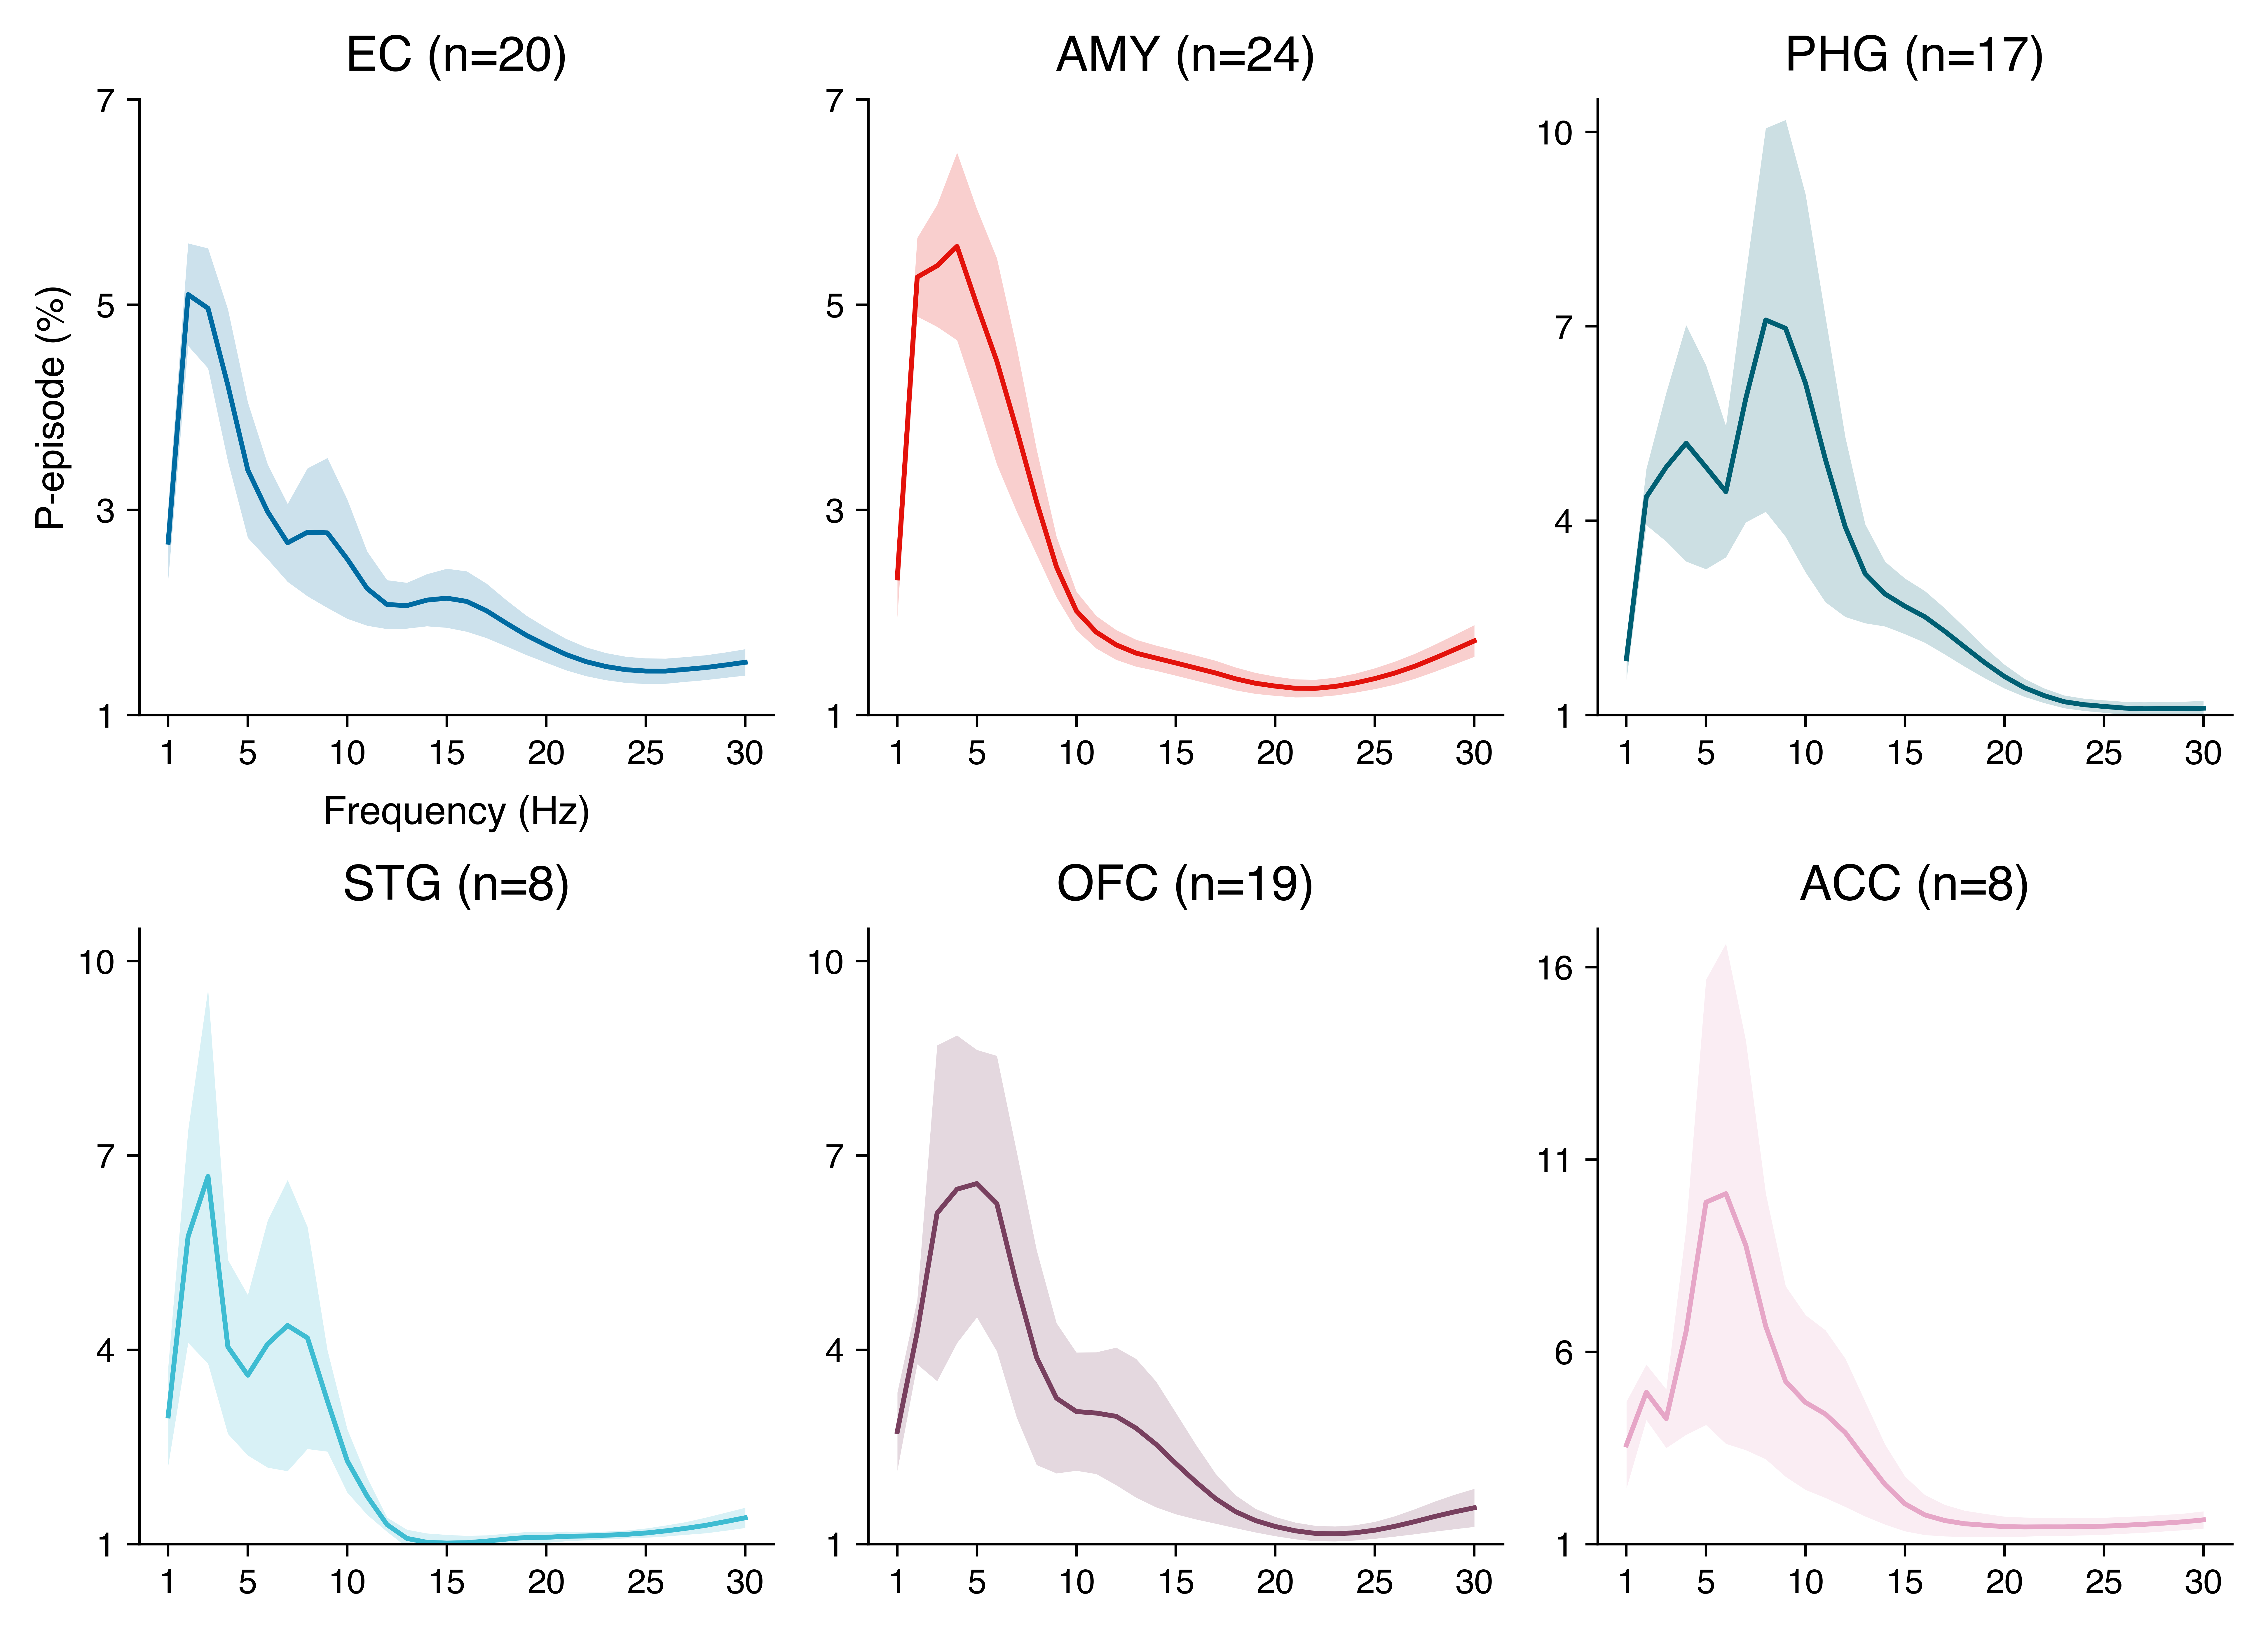

In [30]:
# Plot P-episode for each region, across electrodes for all subjects.
expmt = 'ycab-goldmine_nav'
roi_col = 'roi_gen'
rois = ['EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
roi_colors = {'HPC': co['k'],
              'EC': co['b'],
              'AMY': co['r'],
              'PHG': co['c6'],
              'STG': co['c'],
              'OFC': co['p6'],
              'ACC': co['p2']}
roi_count = pep_pct_agg1.groupby(roi_col).size()
figsize = (colws[3], colws[3]*0.72)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
linewidth = 1
spine_lw = 0.5
labelpad = 5
tickpad = 2.5
ticklen = 2.5
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
# ylim = (0, 16)
# yticks = [0, 4, 8, 12, 16]
ylim = {'HPC': (1, 7),
        'EC': (1, 7),
        'AMY': (1, 7),
        'PHG': (1, 10.5),
        'STG': (1, 10.5),
        'OFC': (1, 10.5),
        'ACC': (1, 17)}
yticks = {'HPC': [0, 2, 4, 6],
          'EC': [1, 3, 5, 7],
          'AMY': [1, 3, 5, 7],
          'PHG': [1, 4, 7, 10],
          'STG': [1, 4, 7, 10],
          'OFC': [1, 4, 7, 10],
          'ACC': [1, 6, 11, 16]}
plot_mean = True
verbose = False
savefig = 0
overwrite = 0

# --------------------------------
# Get the data.
means = pep_pct_agg1.groupby(roi_col)[freqs].mean() * 100
stds = pep_pct_agg1.groupby(roi_col)[freqs].std() * 100
sems = pep_pct_agg1.groupby(roi_col)[freqs].sem() * 100
medians = pep_pct_agg1.groupby(roi_col)[freqs].median() * 100
q1 = pep_pct_agg1.groupby(roi_col)[freqs].agg({freq: lambda x: np.percentile(x, 25) * 100 for freq in freqs})
q3 = pep_pct_agg1.groupby(roi_col)[freqs].agg({freq: lambda x: np.percentile(x, 75) * 100 for freq in freqs})

# Plot the data.
plt.close()
fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, roi in enumerate(rois):
    _ax = ax[iax]
    if plot_mean:
        _ax.fill_between(xvals,
                         means.loc[roi].values + sems.loc[roi].values,
                         means.loc[roi].values - sems.loc[roi].values,
                         alpha=0.2, lw=0, color=roi_colors[roi])
        _ax.plot(xvals, means.loc[roi].values,
                 lw=1, color=roi_colors[roi])
    else:
        _ax.fill_between(xvals, q3.loc[roi].values, q1.loc[roi].values,
                         alpha=0.2, lw=0, color=roi_colors[roi])
        _ax.plot(xvals, medians.loc[roi].values,
                 lw=1, color=roi_colors[roi])
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    
    _ax.set_ylim(ylim[roi])
    _ax.set_yticks(yticks[roi])
    _ax.set_yticklabels(yticks[roi], fontsize=font['tick'])
    _ax.set_title('{} (n={})'.format(roi, roi_count[roi]), fontsize=font['fig'])
    if iax == 0:
        _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('P-episode (%)', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.set_xlabel('')
        _ax.set_ylabel('')
        
fig.tight_layout()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2', 
                       'p_episode-{}-{}subjs-{}ec_{}amy_{}phg_{}stg_{}ofc_{}acc_elecs.pdf'
                       .format(expmt,
                               pep_pct_agg1['subj'].unique().size,
                               roi_count['EC'],
                               roi_count['AMY'],
                               roi_count['PHG'],
                               roi_count['STG'],
                               roi_count['OFC'],
                               roi_count['ACC']))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

# Oscillatory synchrony analysis

In [39]:
def dice(u, v):
    """Return the Dice similarity coefficient between arrays u and v."""
    nuv = (u & v).sum()
    nu = u.sum()
    nv = v.sum()
    return (2 * nuv) / (nu + nv)

In [40]:
def u_in_v(u, v):
    """Return (u & v) / v."""
    nuv = (u & v).sum()
    nv = v.sum()
    return nuv / nv

In [5]:
# Load oscillatory sync dataframes.
expmts = ['goldmine', 'ycab']

# ----------------------
data_dirs = {'goldmine': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/p_episode',
             'ycab': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab/p_episode'}

osc_sync = pd.concat([dio.open_pickle(op.join(data_dirs[expmt], 'osc_sync.pkl'))
                      for expmt in expmts], axis=0).reset_index(drop=True)

print('osc_sync: {}'.format(osc_sync.shape))

osc_sync: (330, 11)


In [41]:
# Calculate overlap at each frequency between all cortex/hippocampus region pairs.
save_output = 0
overwrite = 0
expmts = ['goldmine', 'ycab']
n_rois = 8
overlap_f = dice # u_in_v
# sync_f = lfp_synchrony.calc_plv

# -------------------------
timer = Timer()

data_dirs = {'goldmine': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav',
             'ycab': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab'}
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/tables'
roi_map = spike_preproc.roi_mapping(n_rois)

osc_sync = []
for expmt in expmts:
    files = glob(op.join(data_dirs[expmt], 'p_episode', 'U*.pkl'))
    sessions = np.unique([op.basename(f).split('-')[0] for f in files])
    _osc_sync = []
    for subj_sess in sessions:
        # Get all region pairs for which one of the regions is hippocampus.        
        subj = subj_sess.split('_')[0]
        hemrois = np.unique([op.basename(f).split('-')[1].replace('.pkl', '')
                             for f in files if subj_sess in f])
        roi_pairs = [(hemrois[ii], hemrois[jj])
                      for ii in range(len(hemrois))
                      for jj in range(len(hemrois))
                      if np.all((ii<jj,
                                 hemrois[ii][0]==hemrois[jj][0],
                                 np.count_nonzero((roi_map[hemrois[ii][1:]]=='HPC',
                                                   roi_map[hemrois[jj][1:]]=='HPC')) == 1))]
        # Make hippocampus the second ROI in each pair.
        roi_pairs = [(roi_pair[0], roi_pair[1])
                      if roi_map[roi_pair[1][1:]]=='HPC'
                      else (roi_pair[1], roi_pair[0])
                      for roi_pair in roi_pairs]
        for roi_pair in roi_pairs:
            hemroi1, hemroi2 = roi_pair
            
#             # Load phase arrays.
#             phase1 = dio.open_pickle(op.join(data_dirs[expmt], 'spectral', 'phase', '{}-{}.pkl'.format(subj_sess, hemroi1)))
#             if (phase1.buffer > 0) & (not phase1.clip_buffer):
#                 phase1 = phase1.loc[:, :, :, phase1.buffer:phase1.time.size-phase1.buffer-1]
#             phase1.attrs['clip_buffer'] = True
#             phase1 = phase1.values
            
#             phase2 = dio.open_pickle(op.join(data_dirs[expmt], 'spectral', 'phase', '{}-{}.pkl'.format(subj_sess, hemroi2)))
#             if (phase2.buffer > 0) & (not phase2.clip_buffer):
#                 phase2 = phase2.loc[:, :, :, phase2.buffer:phase2.time.size-phase2.buffer-1]
#             phase2.attrs['clip_buffer'] = True
#             phase2 = phase2.values
            
            # Load the oscillation masks.
            osc_mask1 = dio.open_pickle(op.join(data_dirs[expmt], 'p_episode', '{}-{}.pkl'.format(subj_sess, hemroi1)))
            if (osc_mask1.buffer > 0) & (not osc_mask1.clip_buffer):
                osc_mask1 = osc_mask1.loc[:, :, :, osc_mask1.buffer:osc_mask1.time.size-osc_mask1.buffer-1]
            osc_mask1.attrs['clip_buffer'] = True
            osc_mask1 = osc_mask1.values
            
            osc_mask2 = dio.open_pickle(op.join(data_dirs[expmt], 'p_episode', '{}-{}.pkl'.format(subj_sess, hemroi2)))
            if (osc_mask2.buffer > 0) & (not osc_mask2.clip_buffer):
                osc_mask2 = osc_mask2.loc[:, :, :, osc_mask2.buffer:osc_mask2.time.size-osc_mask2.buffer-1]
            osc_mask2.attrs['clip_buffer'] = True
            osc_mask2 = osc_mask2.values
            
            # Calculate the oscillatory percentage at each freuqency,
            # in each region.
            peps1 = list(100 * np.nanmean(osc_mask1, axis=(0, 1, 3)))
            peps2 = list(100 * np.nanmean(osc_mask2, axis=(0, 1, 3)))
            
            # Calculate the mean overlap and phase-locking value
            # for all possible pairs of channels between regions 1 and 2.
            chan_pairs = [(ii, jj)
                          for ii in range(osc_mask1.shape[1])
                          for jj in range(osc_mask2.shape[1])]
            n_freq = osc_mask1.shape[2]
            mean_overlap = np.nanmean([[overlap_f(osc_mask1[:, iChan1, iFreq, :],
                                                  osc_mask2[:, iChan2, iFreq, :])
                                        for iFreq in range(n_freq)]
                                       for (iChan1, iChan2) in chan_pairs],
                                      axis=0).tolist() 
            
#             mean_sync = np.nanmean([[np.nanmean(sync_f(phase1[:, iChan1, iFreq, :],
#                                                        phase2[:, iChan2, iFreq, :]))
#                                      for iFreq in range(n_freq)]
#                                     for (iChan1, iChan2) in chan_pairs],
#                                    axis=0).tolist()
            
            # Append to the output dataframe.
            _osc_sync.append([expmt,
                              subj,
                              subj_sess,
                              hemroi1,
                              roi_map[hemroi1[1:]],
                              hemroi2,
                              roi_map[hemroi2[1:]],
                              peps1,
                              peps2,
                              overlap_f.__name__,
                              mean_overlap,
#                               sync_f.__name__,
#                               mean_sync
                             ])
            
        timer.loop(subj_sess)
    
    # Create the output dataframe.
    cols = ['expmt',
            'subj',
            'subj_sess',
            'hemroi1',
            'roi_gen1',
            'hemroi2',
            'roi_gen2',
            'peps1',
            'peps2',
            'overlap_func',
            'overlap'
           ]
    _osc_sync = pd.DataFrame(_osc_sync, columns=cols)
    osc_sync.append(_osc_sync)
    
osc_sync = pd.concat(osc_sync, axis=0).reset_index(drop=True)

# Save the output dataframe.
if save_output:
    output_file = op.join(output_dir, 'osc_sync.pkl')
    if overwrite or not op.exists(output_file):
        dio.save_pickle(_osc_sync, output_file)

print('osc_sync: {}'.format(osc_sync.shape))
print(timer)

U518_ses0: 111.4s
U518_ses1: 101.5s


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


U521_ses0: 95.2s
U526_ses0: 78.3s
U527_ses0: 93.6s
U530_ses0: 143.6s
U530_ses1: 137.8s
U532_ses0: 43.1s
U536_ses0: 122.9s
U537_ses0: 61.6s
U539_ses0: 74.9s
U540_ses0: 84.7s
U369_ses1: 49.8s
U369_ses2: 28.8s
U370_ses1: 63.9s
U371_ses1: 118.2s
U371_ses2: 105.6s
U371_ses3: 82.4s
U372_ses1: 61.8s
U372_ses2: 67.7s
U373_ses1: 41.6s
U373_ses2: 29.7s
U373_ses3: 29.1s
U374_ses1: 43.6s
U374_ses2: 37.5s
U379_ses1: 41.4s
U380_ses1: 44.8s
U380_ses2: 49.0s
U380_ses3: 53.3s
U381_ses1: 67.5s
U381_ses2: 50.1s
U381_ses3: 53.4s
U384_ses1: 91.0s
U384_ses2: 74.0s
U384_ses3: 31.7s
U385_ses1: 56.9s
U385_ses2: 43.4s
U385_ses3: 40.7s
U385_ses4: 39.8s
U387_ses1: 111.0s
U387_ses2: 67.6s
U387_ses3: 76.2s
U390_ses1: 46.1s
U390_ses2: 36.6s
U390_ses3: 37.4s
U390_ses4: 35.6s
U392_ses1: 72.4s
U393_ses2: 102.6s
U394_ses1: 42.1s
U394_ses3: 31.4s
U395_ses1: 60.7s
U395_ses2: 66.1s
U395_ses3: 59.2s
U396_ses2: 63.5s
U396_ses3: 80.8s
osc_sync: (330, 11)
Ran in 3634.6s


In [43]:
stat = 'overlap'
keep_expmts = ['goldmine']
freqs = np.arange(1, 31)

agg_df = (osc_sync
          .query("(expmt=={})".format(keep_expmts))
          .groupby(['subj', 'roi_gen1'])[stat]
          .apply(lambda x: np.nanmean(np.array(x.tolist()), axis=0))
          .reset_index())
for iFreq, freq in enumerate(freqs):
    agg_df[freq] = agg_df[stat].apply(lambda x: x[iFreq])
agg_df.drop(columns=stat, inplace=True)

means = agg_df.groupby('roi_gen1')[freqs].mean() * 100
sems = agg_df.groupby('roi_gen1')[freqs].sem() * 100

print(np.max(means.values + sems.values))

31.60478891795065


In [48]:
osc_sync_copy = osc_sync.copy()

In [51]:
osc_sync.query("(hemroi1=={}) | (hemroi2=={})"
               .format(['LMC', 'LPC', 'LTP', 'RMC', 'RPC', 'RTP'],
                       ['LMC', 'LPC', 'LTP', 'RMC', 'RPC', 'RTP'])
              ).shape

(12, 11)

In [59]:
osc_sync = osc_sync_copy.copy()

In [60]:
# Drop unwanted regions.
drop_idx = osc_sync.loc[np.isin(osc_sync['roi_gen1'], 'Other') | np.isin(osc_sync['roi_gen2'], 'Other')].index
osc_sync = osc_sync.drop(index=drop_idx).reset_index(drop=True)

drop_rois = ['MC', 'PC', 'TP']
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC']
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']

for cxn in ['1', '2']:
    osc_sync.insert(osc_sync.columns.tolist().index('hemroi{}'.format(cxn))+1,
                   'roi{}'.format(cxn),
                   osc_sync['hemroi{}'.format(cxn)].apply(lambda x: x[1:]))
    osc_sync = osc_sync.query("(roi{}!={})".format(cxn, drop_rois)).reset_index(drop=True)

    osc_sync['roi_gen{}'.format(cxn)] = osc_sync['roi_gen{}'.format(cxn)].astype(str)
    osc_sync.loc[osc_sync['roi_gen{}'.format(cxn)]=='CC', 'roi_gen{}'.format(cxn)] = 'ACC'
    osc_sync.loc[osc_sync['roi_gen{}'.format(cxn)]=='LTC', 'roi_gen{}'.format(cxn)] = 'STG'
    osc_sync['roi_gen{}'.format(cxn)] = osc_sync['roi_gen{}'.format(cxn)].astype(pd.CategoricalDtype(gen_rois, ordered=True))

    osc_sync.insert(osc_sync.columns.tolist().index('roi_gen{}'.format(cxn))+1, 'roi_jen{}'.format(cxn), '')
    osc_sync.loc[np.isin(osc_sync['hemroi{}'.format(cxn)].apply(lambda x: x[1:]), hpc_rois), 'roi_jen{}'.format(cxn)] = 'HPC'
    osc_sync.loc[np.isin(osc_sync['hemroi{}'.format(cxn)].apply(lambda x: x[1:]), mtl_rois), 'roi_jen{}'.format(cxn)] = 'MTL'
    osc_sync.loc[~np.isin(osc_sync['hemroi{}'.format(cxn)].apply(lambda x: x[1:]), hpc_rois + mtl_rois), 'roi_jen{}'.format(cxn)] = 'CTX'
    osc_sync['roi_jen{}'.format(cxn)] = osc_sync['roi_jen{}'.format(cxn)].astype(pd.CategoricalDtype(gen_rois2, ordered=True))
    
print('osc_sync: {}'.format(osc_sync.shape))

osc_sync: (271, 15)


In [63]:
osc_sync.groupby(['roi_gen1', 'roi_gen2'], observed=True).size()

roi_gen1  roi_gen2
EC        HPC         58
AMY       HPC         69
PHG       HPC         47
STG       HPC         26
OFC       HPC         48
ACC       HPC         23
dtype: int64

In [65]:
osc_sync.groupby(['roi_gen1'], observed=True).size()

roi_gen1
EC     58
AMY    69
PHG    47
STG    26
OFC    48
ACC    23
dtype: int64

In [66]:
osc_sync.head()

expmt  subj  subj_sess hemroi1 roi1 roi_gen1 roi_jen1 hemroi2 roi2  \
0  goldmine  U518  U518_ses0      LA    A      AMY      MTL     LMH   MH   
1  goldmine  U518  U518_ses0    LPHG  PHG      PHG      CTX     LMH   MH   
2  goldmine  U518  U518_ses0    LSTS  STS      STG      CTX     LMH   MH   
3  goldmine  U518  U518_ses1      LA    A      AMY      MTL     LMH   MH   
4  goldmine  U518  U518_ses1    LPHG  PHG      PHG      CTX     LMH   MH   

  roi_gen2 roi_jen2                                              peps1  \
0      HPC      HPC  [3.057824074074074, 2.6481770833333336, 1.9662...   
1      HPC      HPC  [7.358200231481482, 4.065943287037037, 5.51719...   
2      HPC      HPC  [6.152332175925926, 13.96677662037037, 24.7409...   
3      HPC      HPC  [3.102512254901961, 3.6336213235294115, 3.4784...   
4      HPC      HPC  [2.979908963585434, 2.7068557422969186, 3.9055...   

                                               peps2 overlap_func  \
0  [2.0695436507936504, 16.368882275132275, 21.63...         dice   
1  [2.0695436507936504, 16.368882275132275, 21.63...         dice   
2  [2.0695436507936504, 16.368882275132275, 21.63...         dice   
3  [2.0216316526610645, 14.762619047619047, 20.63...         dice   
4  [2.0216316526610645, 14.762619047619047, 20.63...         dice   

                                             overlap  
0  [0.030781822402861713, 0.08321587705825209, 0....  
1  [0.03149837938163024, 0.07718396203693956, 0.1...  
2  [0.0459802671342826, 0.19055379703274844, 0.31...  
3  [0.02683780889089851, 0.12884598239425196, 0.1...  
4  [0.07186882496747586, 0.06124900688719146, 0.0...

In [74]:
_means = (osc_sync
          .query("(expmt=={})".format(keep_expmts))
          .groupby(['roi_gen1'], observed=True)[stat]
          .apply(lambda x: np.nanmean(np.array(x.tolist()), axis=0))
          .reset_index())
for iFreq, freq in enumerate(freqs):
    _means[freq] = _means[stat].apply(lambda x: x[iFreq])
_means.drop(columns=stat, inplace=True)
_means = _means.set_index('roi_gen1')
_means

1         2         3         4         5         6   \
roi_gen1                                                               
EC        0.125942  0.220544  0.222904  0.224931  0.204453  0.203552   
AMY       0.084032  0.128440  0.128115  0.140637  0.163008  0.192143   
PHG       0.097354  0.131304  0.140766  0.139727  0.135259  0.120224   
STG       0.034465  0.109624  0.144939  0.088396  0.051369  0.048850   
OFC       0.085100  0.095279  0.093183  0.127658  0.164657  0.165539   
ACC       0.134487  0.120366  0.137110  0.173749  0.210867  0.242372   

                7         8         9         10        11        12  \
roi_gen1                                                               
EC        0.228292  0.262244  0.263019  0.236683  0.209163  0.187662   
AMY       0.205139  0.207286  0.193844  0.184431  0.176766  0.163681   
PHG       0.113424  0.100935  0.095182  0.091717  0.086424  0.087628   
STG       0.045325  0.042970  0.040882  0.040886  0.037887  0.041213   
OFC       0.137768  0.102179  0.089881  0.080954  0.073718  0.063098   
ACC       0.250554  0.209786  0.175022  0.131871  0.094173  0.069950   

                13        14        15        16        17        18  \
roi_gen1                                                               
EC        0.179705  0.180447  0.174431  0.171012  0.173160  0.169078   
AMY       0.142010  0.132124  0.126612  0.123886  0.120963  0.114037   
PHG       0.093455  0.103989  0.107854  0.106723  0.105920  0.105888   
STG       0.039735  0.041822  0.043067  0.040364  0.038536  0.037234   
OFC       0.055744  0.056268  0.054757  0.051356  0.047086  0.045758   
ACC       0.058392  0.051182  0.042265  0.036777  0.034473  0.034291   

                19        20        21        22        23        24  \
roi_gen1                                                               
EC        0.168627  0.165972  0.164029  0.163608  0.163860  0.164751   
AMY       0.109618  0.106033  0.102894  0.099179  0.096133  0.094101   
PHG       0.102783  0.102233  0.099499  0.096611  0.090823  0.085175   
STG       0.039080  0.038267  0.037685  0.038053  0.038680  0.039787   
OFC       0.044179  0.042612  0.041291  0.040601  0.039871  0.038736   
ACC       0.034752  0.034419  0.033563  0.034418  0.034683  0.033070   

                25        26        27        28        29        30  
roi_gen1                                                              
EC        0.166734  0.168629  0.169345  0.168236  0.170220  0.170030  
AMY       0.092838  0.093116  0.092206  0.093183  0.093878  0.093207  
PHG       0.080294  0.073364  0.067949  0.065048  0.061955  0.059019  
STG       0.041383  0.040445  0.040593  0.040885  0.042153  0.043881  
OFC       0.037592  0.035935  0.035001  0.034747  0.034384  0.033894  
ACC       0.031940  0.030788  0.030510  0.031324  0.033657  0.033905

In [87]:
np.max((_means + _sems).values)

0.19724315568519193

In [92]:
osc_sync['subj'].nunique()

28

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/p_episode/osc_sync-dice-ycab-goldmine_nav-28subjs-58EC_69AMY_47PHG_26STG_48OFC_23ACC_elecs.pdf


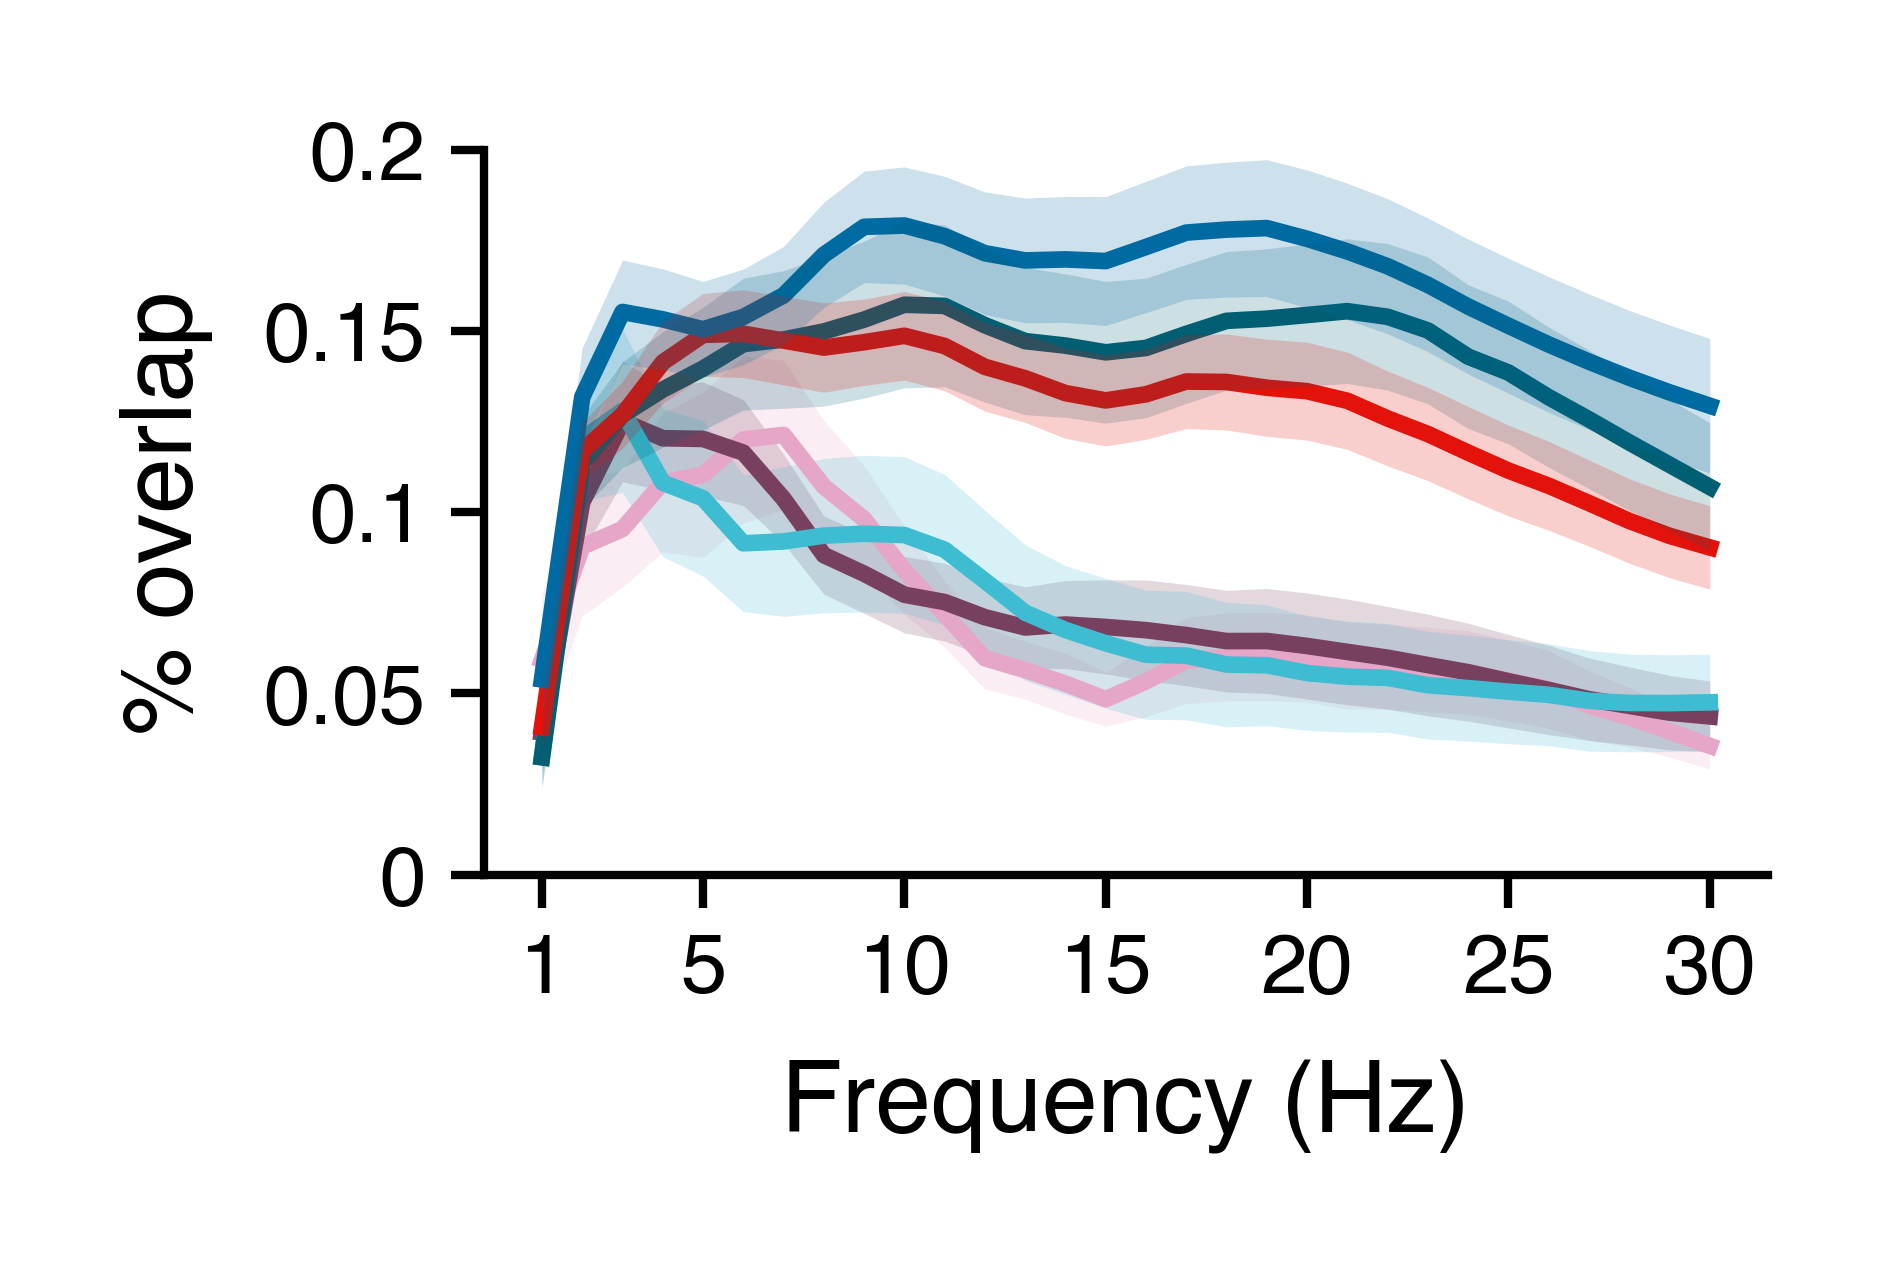

In [93]:
# Plot P-episode for each region, across electrodes for all subjects.
savefig = 0
overwrite = 1
keep_expmts = ['ycab', 'goldmine']
stat = 'overlap'
freqs = np.arange(1, 31)
expmt = 'ycab-goldmine_nav'
rois = gen_rois[1:]
roi_colors = {'HPC': co['x4'],
              'EC': co['b'],
              'AMY': co['r'],
              'PHG': co['c6'],
              'STG': co['c'],
              'OFC': co['p6'],
              'ACC': co['p2']}
roi_count = osc_sync.groupby(['roi_gen1'], observed=True).size()
figsize = (colws[1], colws[1]*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
linewidth = 1
spine_lw = 0.5
labelpad = 3
tickpad = 1.5
ticklen = 2
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
# ylim = (0, 33)
# yticks = [0, 5, 10, 15, 20, 25, 30]
ylim = (0, 0.2)
yticks = [0, 0.05, 0.1, 0.15, 0.2]
yticklabs = yticks
plot_mean = True
verbose = False

# --------------------------------
# Get the data.
agg_df = (osc_sync
          .query("(expmt=={})".format(keep_expmts))
          .groupby(['roi_gen1'], observed=True)[stat]
          .apply(lambda x: np.nanmean(np.array(x.tolist()), axis=0))
          .reset_index())
for iFreq, freq in enumerate(freqs):
    agg_df[freq] = agg_df[stat].apply(lambda x: x[iFreq])
agg_df.drop(columns=stat, inplace=True)

means = agg_df.groupby('roi_gen1')[freqs].mean()
stds = agg_df.groupby('roi_gen1')[freqs].std()
sems = agg_df.groupby('roi_gen1')[freqs].sem()
medians = agg_df.groupby('roi_gen1')[freqs].median()
q1 = agg_df.groupby('roi_gen1')[freqs].agg({freq: lambda x: np.percentile(x, 25) for freq in freqs})
q3 = agg_df.groupby('roi_gen1')[freqs].agg({freq: lambda x: np.percentile(x, 75) for freq in freqs})

_means = (osc_sync
          .query("(expmt=={})".format(keep_expmts))
          .groupby(['roi_gen1'], observed=True)[stat]
          .apply(lambda x: np.nanmean(np.array(x.tolist()), axis=0))
          .reset_index())
for iFreq, freq in enumerate(freqs):
    _means[freq] = _means[stat].apply(lambda x: x[iFreq])
_means.drop(columns=stat, inplace=True)
_means = _means.set_index('roi_gen1')

_sems = (osc_sync
         .query("(expmt=={})".format(keep_expmts))
         .groupby(['roi_gen1'], observed=True)[stat]
         .apply(lambda x: stats.sem(np.array(x.tolist()), axis=0, nan_policy='omit'))
         .reset_index())
for iFreq, freq in enumerate(freqs):
    _sems[freq] = _sems[stat].apply(lambda x: x[iFreq])
_sems.drop(columns=stat, inplace=True)
_sems = _sems.set_index('roi_gen1')

# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax  = ax[iax]
for iRoi, roi in enumerate(rois[::-1]):
    _ax.fill_between(xvals,
                     _means.loc[roi].values + _sems.loc[roi].values,
                     _means.loc[roi].values - _sems.loc[roi].values,
                     alpha=0.2, lw=0, color=roi_colors[roi], zorder=iRoi)
    _ax.plot(xvals, _means.loc[roi].values,
             lw=1, color=roi_colors[roi])

for spine in ['left', 'bottom']:
    _ax.spines[spine].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
#     _ax.set_title('{} (n={})'.format(roi, roi_count[roi]), fontsize=font['fig'])
if iax == 0:
    _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('% overlap', fontsize=font['label'], labelpad=labelpad)
else:
    _ax.set_xlabel('')
    _ax.set_ylabel('')
        
fig.tight_layout()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2/p_episode', 
                       'osc_sync-dice-{}-{}subjs-{}_elecs.pdf'
                       .format(expmt,
                               osc_sync['subj'].nunique(),
                               '_'.join(['{}{}'.format(roi_count[roi], roi) for roi in rois])))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('.pdf', '.png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

# FOOOF analysis

In [3]:
def load_fooof(foof_group_file):
    """Load and return a saved FOOOFGroup object."""
    output_dir, basename = op.split(foof_group_file)
    subj_sess, roi = basename.replace('.json', '').split('-')
    foof_group = FOOOFGroup()
    foof_group.load(basename, output_dir)
    return (subj_sess, roi, foof_group)

In [4]:
# Load FOOOF outputs.
# data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab'
# data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/delay'
data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'

fooof_files = glob(op.join(data_dir, 'fooof', '*.json'))
foof_dat = (pd.DataFrame([load_fooof(f) for f in fooof_files],
                         columns=['subj_sess', 'roi', 'foof_group'])
            .set_index(['subj_sess', 'roi']))

In [5]:
# Make a dataframe of aggregated data for each fooof group
# (i.e. all channels and events for one microwire bundle)
foof_res = pd.DataFrame(data=None, index=foof_dat.index.copy())
foof_res['error'] = foof_dat['foof_group'].apply(lambda x: np.nanmedian([foof.error for foof in x.group_results]))
foof_res['r2'] = foof_dat['foof_group'].apply(lambda x: np.nanmedian([foof.r_squared for foof in x.group_results]))
foof_res['offset'] = foof_dat['foof_group'].apply(lambda x: np.nanmedian([foof.aperiodic_params[0] for foof in x.group_results]))
foof_res['exponent'] = foof_dat['foof_group'].apply(lambda x: np.nanmedian([foof.aperiodic_params[1] for foof in x.group_results]))
foof_res['peaks'] = foof_dat['foof_group'].apply(lambda x: np.nanmedian(x.n_peaks_))
foof_res['peak_freq'] = foof_dat['foof_group'].apply(lambda x: x.get_params('peak_params', 'CF')[:, 0].tolist())
foof_res['peak_power'] = foof_dat['foof_group'].apply(lambda x: x.get_params('peak_params', 'PW')[:, 0].tolist())
foof_res['peak_bandwidth'] = foof_dat['foof_group'].apply(lambda x: x.get_params('peak_params', 'BW')[:, 0].tolist())

# Make a dataframe for each oscillatory peak identified across all FOOOF groups.
has_peak_idx = np.where(foof_res['peak_freq'].apply(len)>0)[0]
foof_peaks = pd.concat((foof_res.iloc[has_peak_idx, :].explode('peak_freq')[['peak_freq']],
                        foof_res.iloc[has_peak_idx, :].explode('peak_power')[['peak_power']],
                        foof_res.iloc[has_peak_idx, :].explode('peak_bandwidth')[['peak_bandwidth']]),
                       axis=1).reset_index()
foof_peaks.rename(columns={col: col.replace('peak_', '') for col in foof_peaks.columns}, inplace=True)
foof_peaks.insert(0, 'subj', foof_peaks['subj_sess'].apply(lambda x: x.split('_')[0]))
roi_map = spike_preproc.roi_mapping(n=5)
foof_peaks.insert(3, 'roi_gen', foof_peaks['roi'].apply(lambda x: roi_map[x[1:]]))
foof_peaks.insert(5, 'freq_bin', foof_peaks['freq'].apply(int))
for col in ['subj', 'subj_sess', 'roi', 'roi_gen']:
    foof_peaks[col] = foof_peaks[col].astype(str)
for col in ['freq', 'freq_bin', 'power', 'bandwidth']:
    foof_peaks[col] = foof_peaks[col].astype(np.float32)
    
# Add some columns to foof_res.
foof_res = foof_res.reset_index()
foof_res.insert(0, 'subj', foof_res['subj_sess'].apply(lambda x: x.split('_')[0]))
foof_res.insert(3, 'roi_gen', foof_res['roi'].apply(lambda x: roi_map[x[1:]]))
for col in ['subj', 'subj_sess', 'roi', 'roi_gen']:
    foof_res[col] = foof_res[col].astype(str)
for col in ['peak_freq', 'peak_power', 'peak_bandwidth']:
    foof_res[col] = foof_res[col].apply(lambda x: np.nanmedian(x))
    foof_res[col] = foof_res[col].astype(np.float32)
for col in ['error', 'r2', 'offset', 'exponent', 'peaks']:
    foof_res[col] = foof_res[col].astype(np.float32)

print('foof_res: {}, foof_peaks: {}'.format(foof_res.shape, foof_peaks.shape))

foof_res: (113, 12), foof_peaks: (40779, 8)


In [44]:
save_output = True
overwrite = False

# -----------------------
def get_n_chan_events(subj_sess,
                      roi,
                      pepdir='/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/p_episode',
                      basename='{}-{}.pkl'):
    """Get the number of channels times events for each region."""
    return np.prod(dio.open_pickle(op.join(pepdir, basename.format(subj_sess, roi))).shape[:2])
    
timer = Timer()

output_f = op.join(data_dir, 'p_episode', 'n_chan_events.pkl')
if op.exists(output_f) and not overwrite:
    n_chan_events = dio.open_pickle(output_f)
else:
    n_chan_events = (foof_res[['subj_sess', 'roi']]
                     .drop_duplicates()
                     .apply(lambda x: get_n_chan_events(x['subj_sess'], x['roi'],
                                                        pepdir=op.join(data_dir, 'p_episode')),
                            axis=1))
    n_chan_events = (pd.merge(foof_res[['subj_sess', 'roi']].reset_index(),
                              n_chan_events.reset_index(),
                              on='index')
                     .drop(columns=['index'])
                     .rename(columns={0: 'n_chan_events'}))
    if save_output:
        dio.save_pickle(n_chan_events, output_f)

foof_res = pd.merge(foof_res, n_chan_events, on=['subj_sess', 'roi'])
foof_peaks = pd.merge(foof_peaks, n_chan_events, on=['subj_sess', 'roi'])

print(timer)

Ran in 0.0s


In [9]:
# Ycab.
# How many electrode bundles do we have in each region,
# and what are their oscillatory properties?
(foof_res
 .groupby(['roi_gen'])
 .agg({'roi': len,
       'error': mean_sem,
       'r2': mean_sem,
       'offset': mean_sem,
       'exponent': mean_sem,
       'peaks': mean_sem,
       'peak_freq': mean_sem,
       'peak_power': mean_sem,
       'peak_bandwidth': mean_sem}))

roi        error           r2       offset     exponent        peaks  \
roi_gen                                                                         
A         54  0.06 ± 0.00  0.99 ± 0.00  6.40 ± 0.10  2.07 ± 0.04  0.22 ± 0.06   
EC        47  0.05 ± 0.00  0.99 ± 0.00  6.19 ± 0.08  1.93 ± 0.04  0.30 ± 0.07   
HPC       83  0.05 ± 0.00  0.99 ± 0.00  6.48 ± 0.05  1.91 ± 0.03  0.42 ± 0.06   
O         81  0.05 ± 0.00  0.99 ± 0.00  6.28 ± 0.06  2.03 ± 0.04  0.35 ± 0.06   
PFC       71  0.07 ± 0.00  0.99 ± 0.00  6.20 ± 0.06  2.04 ± 0.04  0.30 ± 0.06   

           peak_freq   peak_power peak_bandwidth  
roi_gen                                           
A        4.01 ± 0.24  0.36 ± 0.01    3.32 ± 0.20  
EC       4.83 ± 0.48  0.33 ± 0.01    3.37 ± 0.27  
HPC      5.99 ± 0.36  0.33 ± 0.01    4.27 ± 0.22  
O        5.07 ± 0.40  0.35 ± 0.01    3.22 ± 0.18  
PFC      3.62 ± 0.31  0.37 ± 0.01    2.84 ± 0.17

In [20]:
# Goldmine delay.
# How many electrode bundles do we have in each region,
# and what are their oscillatory properties?
(foof_res
 .groupby(['roi_gen'])
 .agg({'roi': len,
       'error': mean_sem,
       'r2': mean_sem,
       'offset': mean_sem,
       'exponent': mean_sem,
       'peaks': mean_sem,
       'peak_freq': mean_sem,
       'peak_power': mean_sem,
       'peak_bandwidth': mean_sem}))

roi        error           r2       offset     exponent        peaks  \
roi_gen                                                                         
A         15  0.06 ± 0.01  0.98 ± 0.00  6.26 ± 0.17  1.52 ± 0.08  0.60 ± 0.13   
EC        14  0.06 ± 0.00  0.98 ± 0.00  6.39 ± 0.14  1.40 ± 0.08  0.93 ± 0.07   
HPC       21  0.06 ± 0.00  0.98 ± 0.00  6.99 ± 0.12  1.56 ± 0.06  0.86 ± 0.08   
O         34  0.05 ± 0.00  0.98 ± 0.00  5.97 ± 0.15  1.39 ± 0.06  0.68 ± 0.09   
PFC       29  0.05 ± 0.00  0.98 ± 0.00  5.87 ± 0.12  1.29 ± 0.06  0.84 ± 0.10   

           peak_freq   peak_power peak_bandwidth  
roi_gen                                           
A        5.28 ± 0.63  0.37 ± 0.02    3.41 ± 0.27  
EC       7.00 ± 1.02  0.34 ± 0.01    4.00 ± 0.36  
HPC      6.62 ± 0.75  0.39 ± 0.03    3.93 ± 0.30  
O        5.62 ± 0.45  0.38 ± 0.03    3.55 ± 0.28  
PFC      5.64 ± 0.31  0.38 ± 0.03    3.27 ± 0.16

In [688]:
# Goldmine nav.
# How many electrode bundles do we have in each region,
# and what are their oscillatory properties?
(foof_res
 .groupby(['roi_gen'])
 .agg({'roi': len,
       'error': mean_sem,
       'r2': mean_sem,
       'offset': mean_sem,
       'exponent': mean_sem,
       'peaks': mean_sem,
       'peak_freq': mean_sem,
       'peak_power': mean_sem,
       'peak_bandwidth': mean_sem}))

roi        error           r2       offset     exponent        peaks  \
roi_gen                                                                         
A         15  0.06 ± 0.01  0.98 ± 0.00  6.35 ± 0.17  1.57 ± 0.09  0.27 ± 0.12   
EC        14  0.05 ± 0.01  0.98 ± 0.01  6.58 ± 0.17  1.52 ± 0.12  0.57 ± 0.14   
HPC       21  0.06 ± 0.00  0.98 ± 0.00  7.06 ± 0.12  1.60 ± 0.06  0.62 ± 0.13   
O         34  0.05 ± 0.00  0.98 ± 0.00  5.93 ± 0.14  1.37 ± 0.06  0.38 ± 0.10   
PFC       29  0.05 ± 0.00  0.99 ± 0.00  5.97 ± 0.11  1.37 ± 0.06  0.62 ± 0.13   

           peak_freq   peak_power peak_bandwidth  
roi_gen                                           
A        4.83 ± 0.48  0.37 ± 0.03    3.82 ± 0.35  
EC       7.43 ± 1.17  0.31 ± 0.01    4.56 ± 0.42  
HPC      7.39 ± 0.98  0.37 ± 0.03    4.25 ± 0.37  
O        4.91 ± 0.44  0.33 ± 0.02    3.74 ± 0.36  
PFC      5.56 ± 0.30  0.39 ± 0.03    3.70 ± 0.28

In [45]:
# Gather subject-level and cross-subject info on FOOOF-detected
# oscillation peaks and P-episode percentage across events,
# grouped by subject, region, and frequency.
freqs = np.arange(1, 31)
agg_f = np.mean
# agg_f = np.median

# -------------------------
timer = Timer()

roi_peaks = []
for idx, df in foof_peaks.groupby(['subj', 'roi_gen']):
    subj, roi = idx
    n_elec_chan_events = (foof_res.query("(subj=='{}') & (roi_gen=='{}')".format(subj, roi))
                          [['subj_sess', 'roi', 'n_chan_events']].drop_duplicates()
                          ['n_chan_events'].sum())
    if n_elec_chan_events == 0:
        continue

    for freq in freqs:
        # n_peaks is the total number of peaks observed across all
        # electrode bundles, channels, and events.
        n_peaks = len(df.query("(freq_bin=={})".format(freq)))

        # n_peaks_norm is the mean probability of observing a peak
        # for any single electrode bundle, channel, and event.
        n_peaks_norm = n_peaks / n_elec_chan_events
        
        roi_peaks.append([subj, roi, freq, n_peaks, n_peaks_norm])
    
roi_peaks = pd.DataFrame(roi_peaks, columns=['subj', 'roi', 'freq', 'n_peaks', 'n_peaks_norm'])

# Calculate the median percentage of peaks for each
# region and frequency, across subjects.
roi_peaks_agg = (roi_peaks.groupby(['roi', 'freq'])
                          .agg({'n_peaks': agg_f,
                                'n_peaks_norm': agg_f})
                          .reset_index())

# Get the average P-episode % at each frequency, grouping by subject and region.
pep_pct_agg = pep_pct.groupby(['subj', 'roi_gen'])[freqs].mean().reset_index().groupby('roi_gen')[freqs].apply(agg_f)

print('roi_peaks: {}, roi_peaks_agg: {}, pep_pct_agg: {}'.format(roi_peaks.shape, roi_peaks_agg.shape, pep_pct_agg.shape))
print('max peak percentage: {:.1%}'.format(roi_peaks_agg['n_peaks_norm'].max()),
      'max p-episode: {:.1%}'.format(np.max(pep_pct_agg.values)), sep='\n')
print(timer)

roi_peaks: (2130, 5), roi_peaks_agg: (150, 4), pep_pct_agg: (5, 30)
max peak percentage: 10.7%
max p-episode: 7.6%
Ran in 9.6s


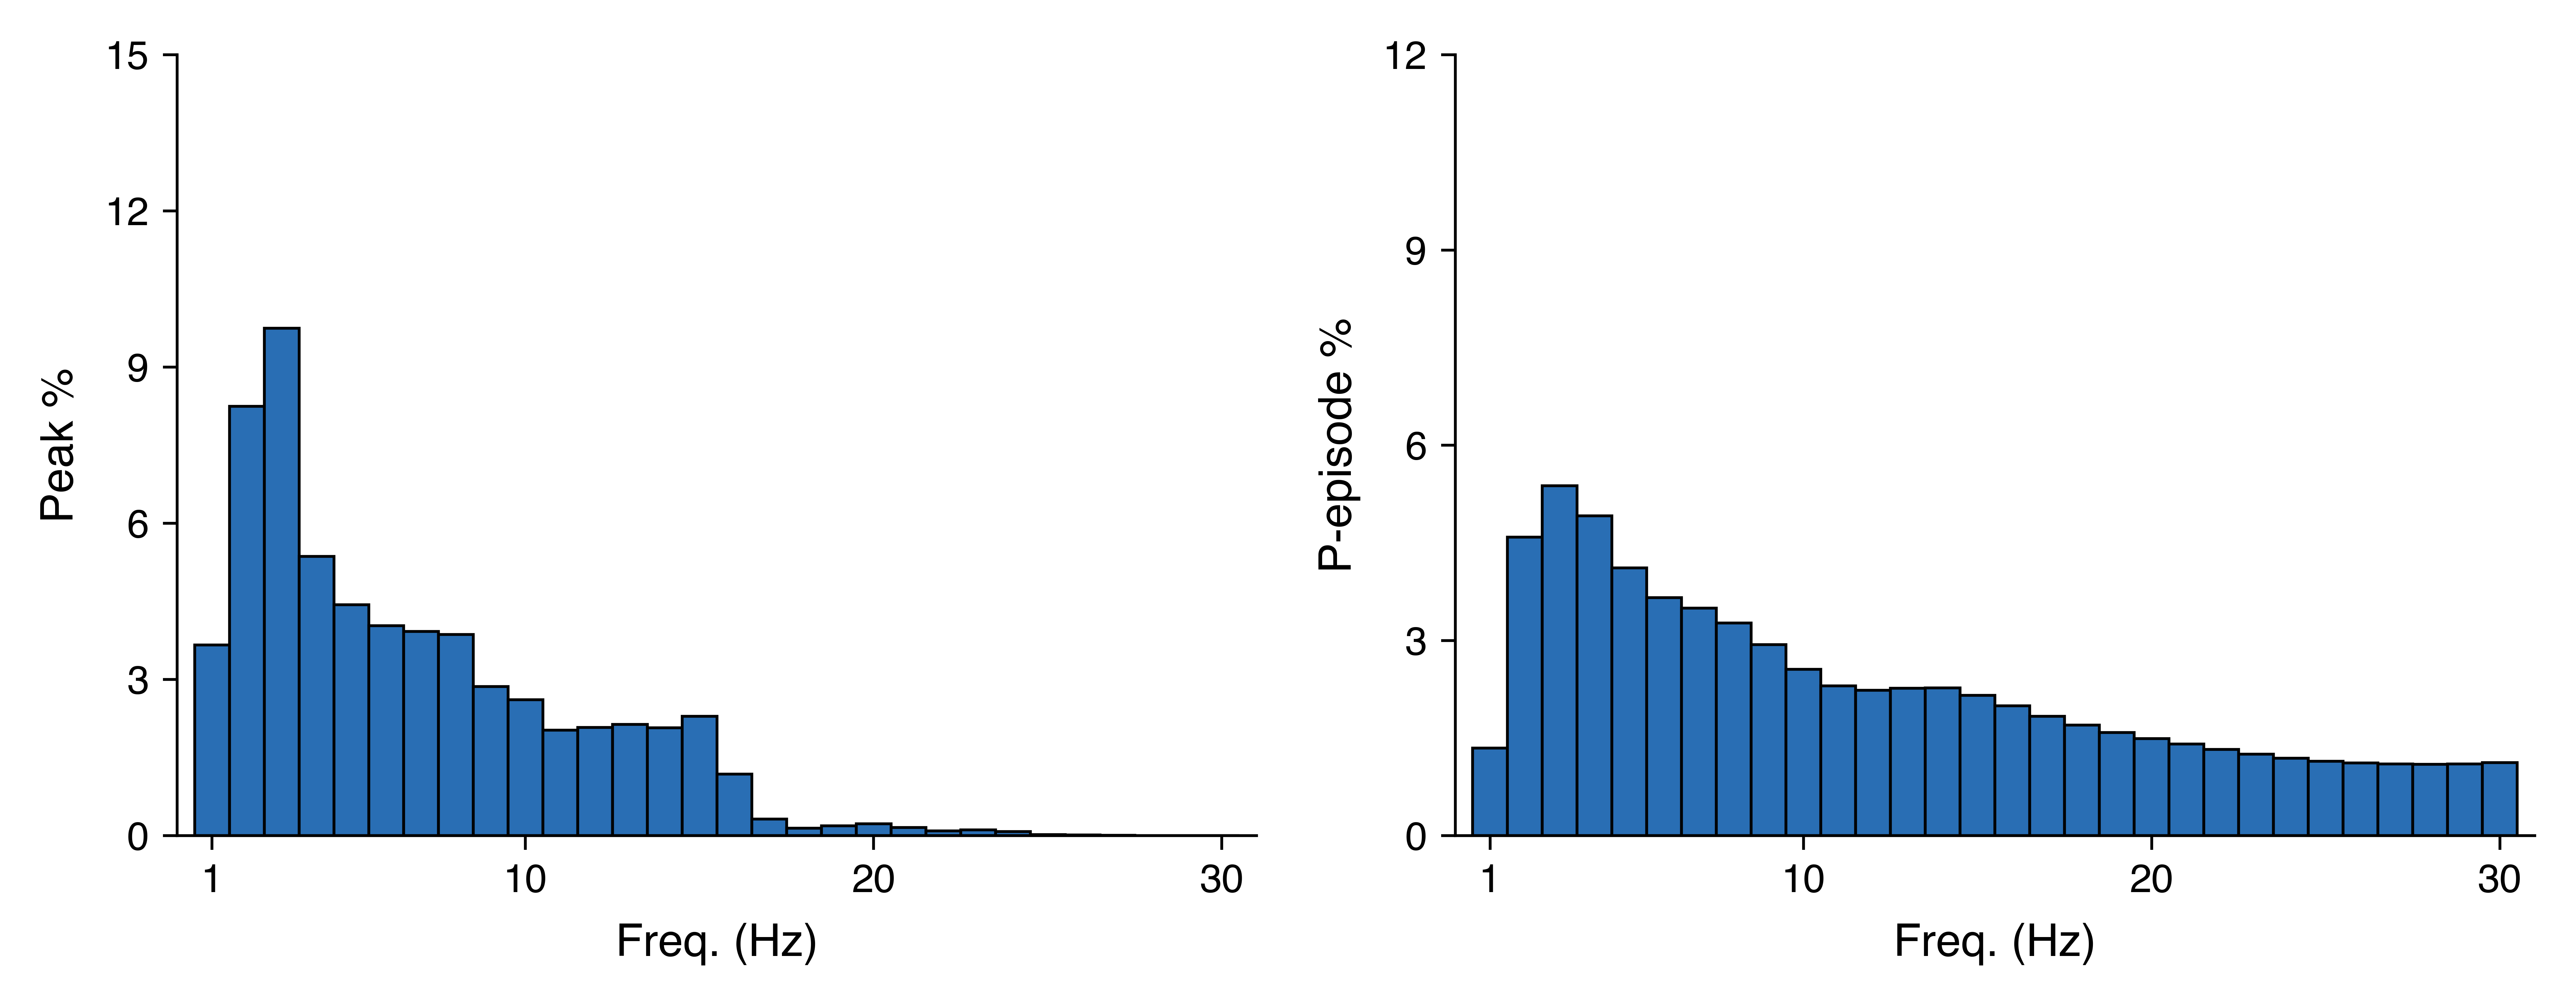

In [46]:
figsize = (colws[3], colws[3]*0.4)
dpi = 1200
savefig = False
overwrite = False
linewidth = 0.5
font = {'tick': 7, 'label': 8, 'fig': 8, 'annot': 7}
spine_lw = 0.5
ticklen = 2.5
tickwidth = 0.5
tickpad = 2.5
labelpad = 4
bar_width = 1
bar_color = colors['b']
bar_lw = 0.5
bar_ec = 'k'
freqs = np.arange(1, 51)
xvals = freqs
xlabel = 'Freq. (Hz)'
ycol = 'n_peaks_norm'
density = False

# -----------------------
plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_roi_peaks_agg = roi_peaks_agg.loc[(roi_peaks_agg['roi']=='HPC'), :].copy()
if density:
    _roi_peaks_agg[ycol] = _roi_peaks_agg[ycol] / np.sum(_roi_peaks_agg[ycol])
else:
    _roi_peaks_agg[ycol] *= 100
_ax.bar(_roi_peaks_agg['freq'], _roi_peaks_agg[ycol],
        width=bar_width, color=bar_color, lw=bar_lw, ec=bar_ec)
xlim = [0, 31]
xticks = [1, 10, 20, 30]
xticklabs = xticks
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
ylim = [0, 15]
yticks = [0, 3, 6, 9, 12, 15]
yticklabs = yticks
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
ylabel = 'Density' if density else 'Peak %'
_ax.set_ylabel(ylabel, fontsize=font['label'], labelpad=labelpad)

# -----------------------
iax = 1
_ax = ax[iax]
_ax.bar(pep_pct_agg.columns, 100 * pep_pct_agg.loc['HPC'], width=bar_width, color=bar_color,
        lw=bar_lw, ec=bar_ec)
xlim = [0, 31]
xticks = [1, 10, 20, 30]
xticklabs = xticks
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
ylim = [0, 12]
yticks = [0, 3, 6, 9, 12]
yticklabs = yticks
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel('P-episode %', fontsize=font['label'], labelpad=labelpad)

for _ax in ax:
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_visible(True)
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], axis='both', which='major',
                    length=ticklen, width=tickwidth, pad=tickpad)
    _ax.set_xlabel(xlabel, fontsize=font['label'], labelpad=labelpad)
    
fig.tight_layout()
fig.show()

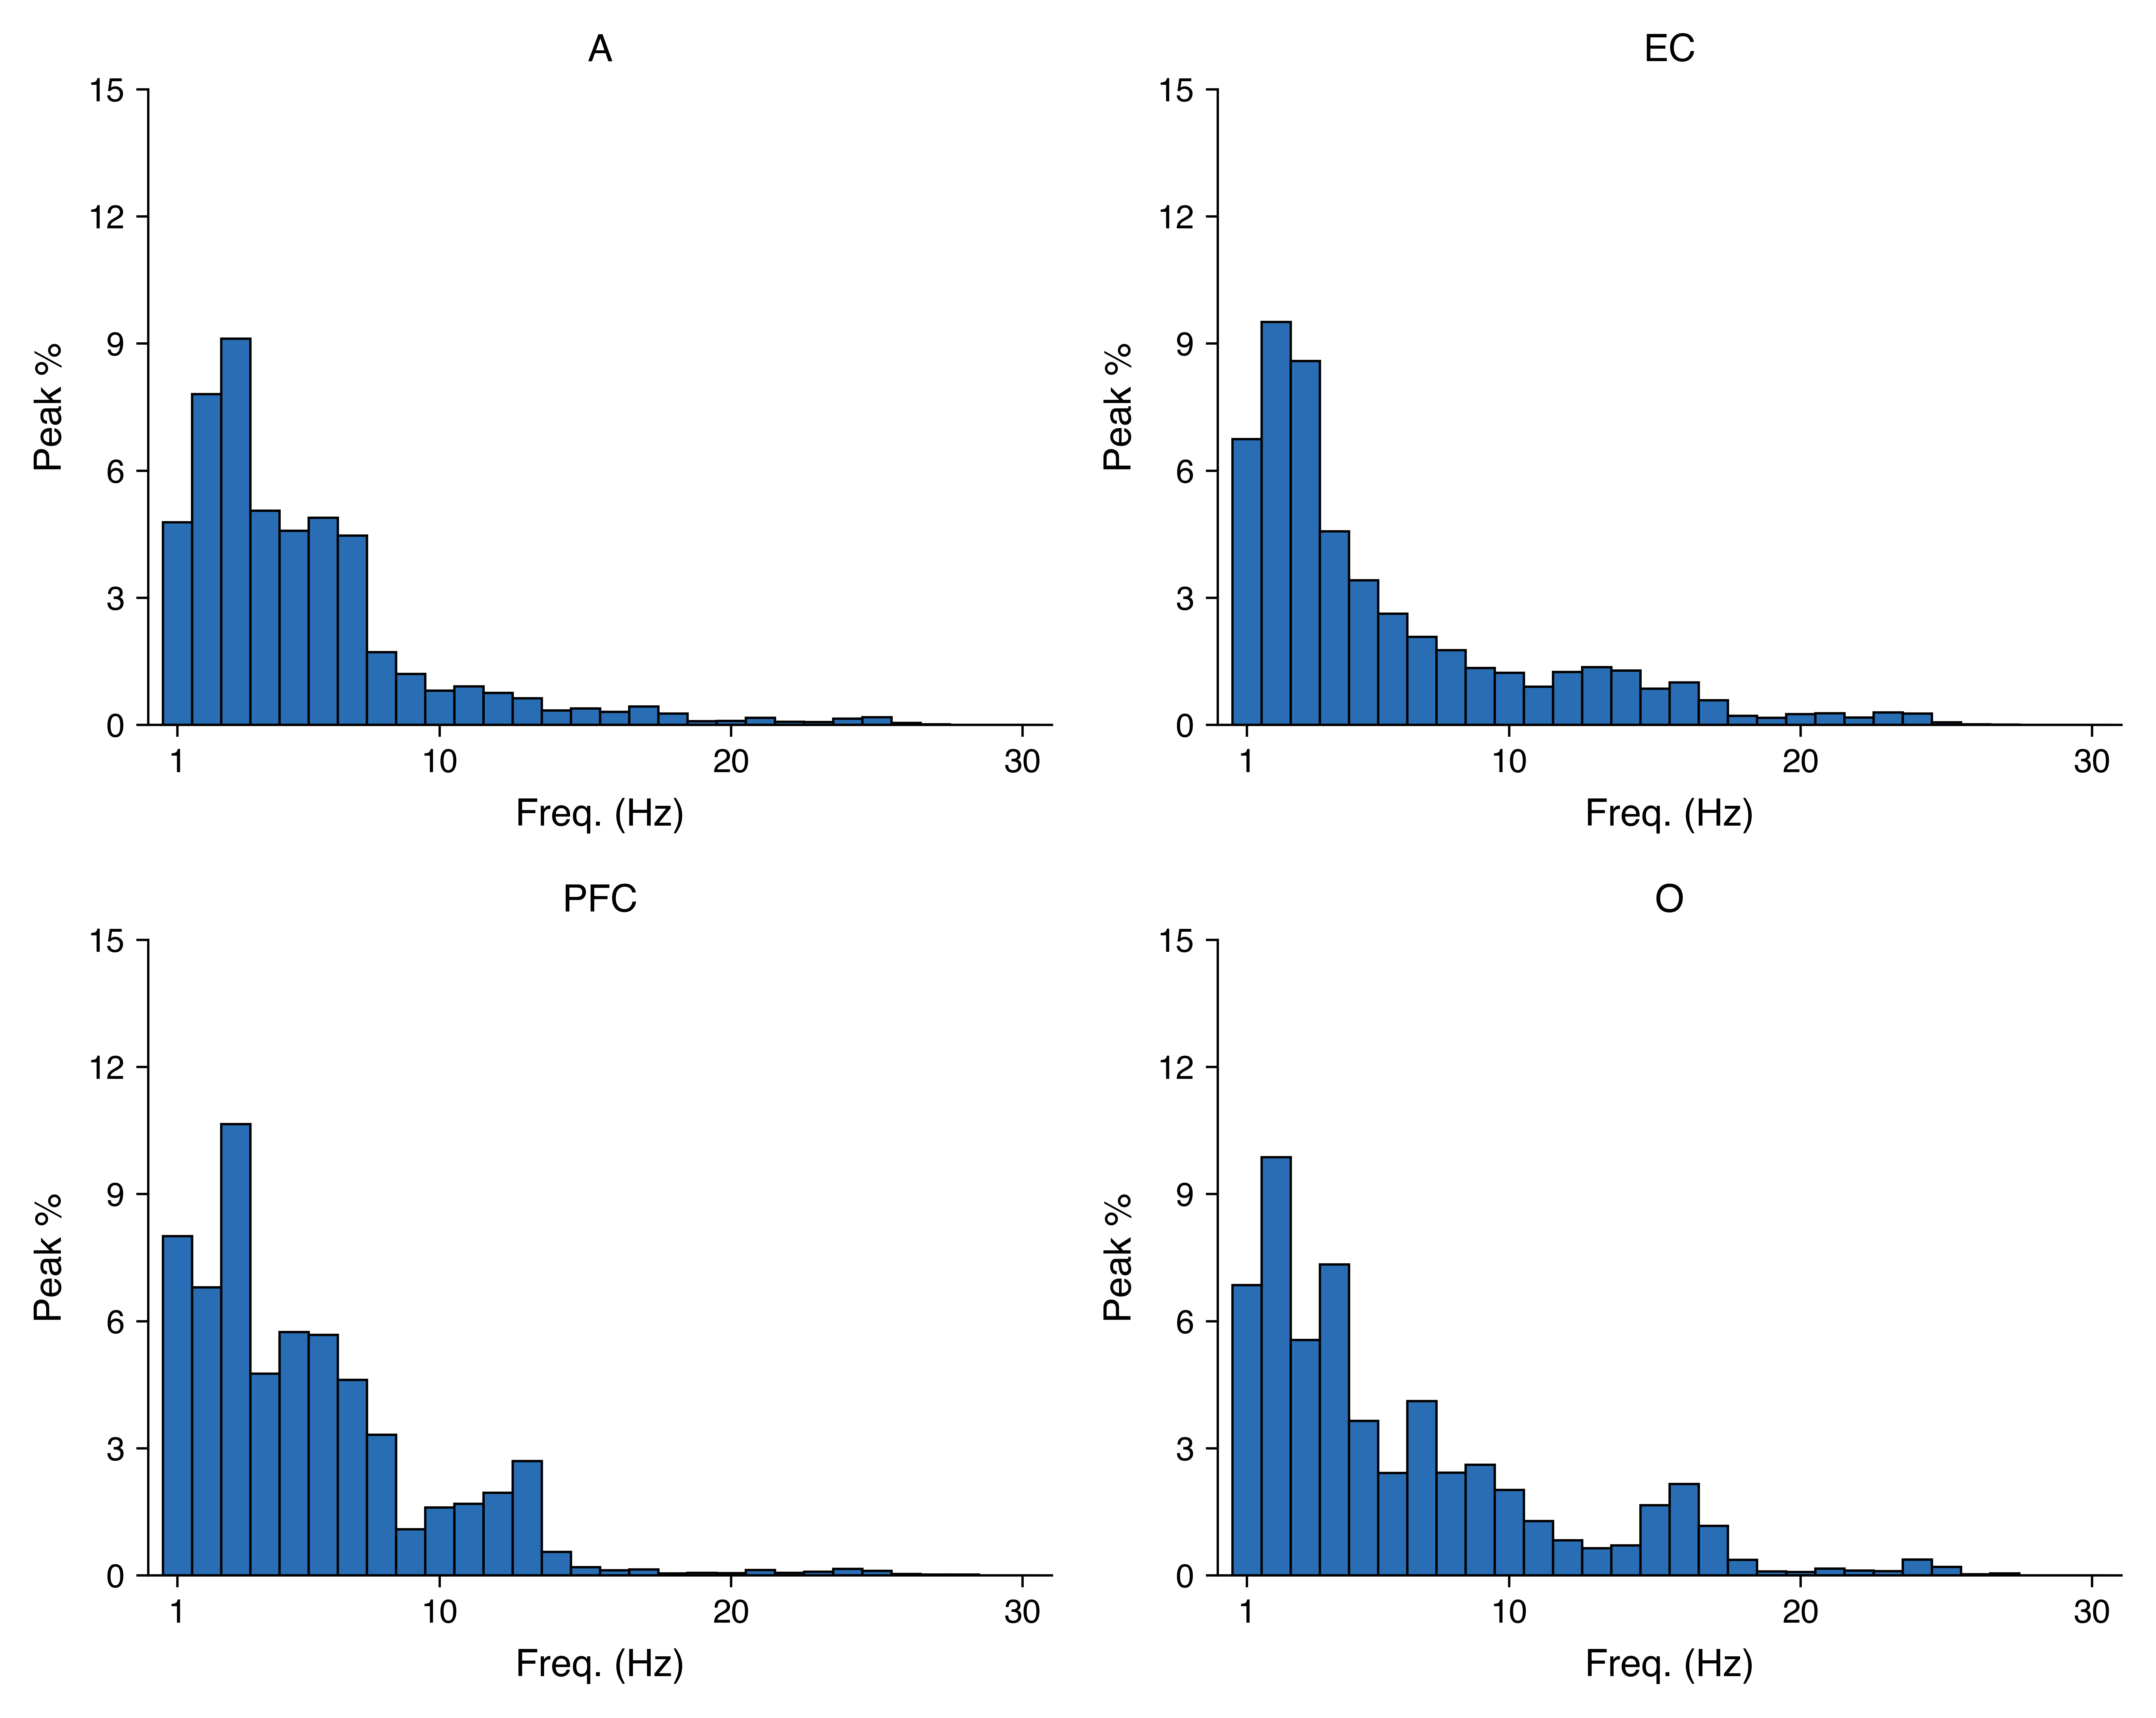

In [47]:
figsize = (colws[3], colws[3]*0.8)
dpi = 1200
savefig = False
overwrite = False
linewidth = 0.5
font = {'tick': 7, 'label': 8, 'fig': 8, 'annot': 7}
spine_lw = 0.5
ticklen = 2.5
tickwidth = 0.5
tickpad = 2.5
labelpad = 4
bar_width = 1
bar_color = colors['b']
bar_lw = 0.5
bar_ec = 'k'
freqs = np.arange(1, 51)
xvals = freqs
xlim = [0, 31]
xticks = [1, 10, 20, 30]
xticklabs = [1, 10, 20, 30]
xlabel = 'Freq. (Hz)'
ycol = 'n_peaks_norm'
density = False
ylim = [0, 15]
yticks = [0, 3, 6, 9, 12, 15]
yticklabs = yticks

# -----------------------
plt.close()
fig, ax = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

rois = ['A', 'EC', 'PFC', 'O']
for iax, roi in enumerate(rois):
    _ax = ax[iax]
    _roi_peaks_agg = roi_peaks_agg.loc[(roi_peaks_agg['roi']==roi), :].copy()
    if density:
        _roi_peaks_agg[ycol] = _roi_peaks_agg[ycol] / np.sum(_roi_peaks_agg[ycol])
    else:
        _roi_peaks_agg[ycol] *= 100
    _ax.bar(_roi_peaks_agg['freq'], _roi_peaks_agg[ycol],
            width=bar_width, color=bar_color, lw=bar_lw, ec=bar_ec)
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_visible(True)
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], axis='both', which='major',
                    length=ticklen, width=tickwidth, pad=tickpad)    
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel(xlabel, fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticklabs)
    ylabel = 'Density' if density else 'Peak %'
    _ax.set_ylabel(ylabel, fontsize=font['label'], labelpad=labelpad)
    _ax.set_title(roi, fontsize=font['fig'])
    
fig.tight_layout()
fig.show()

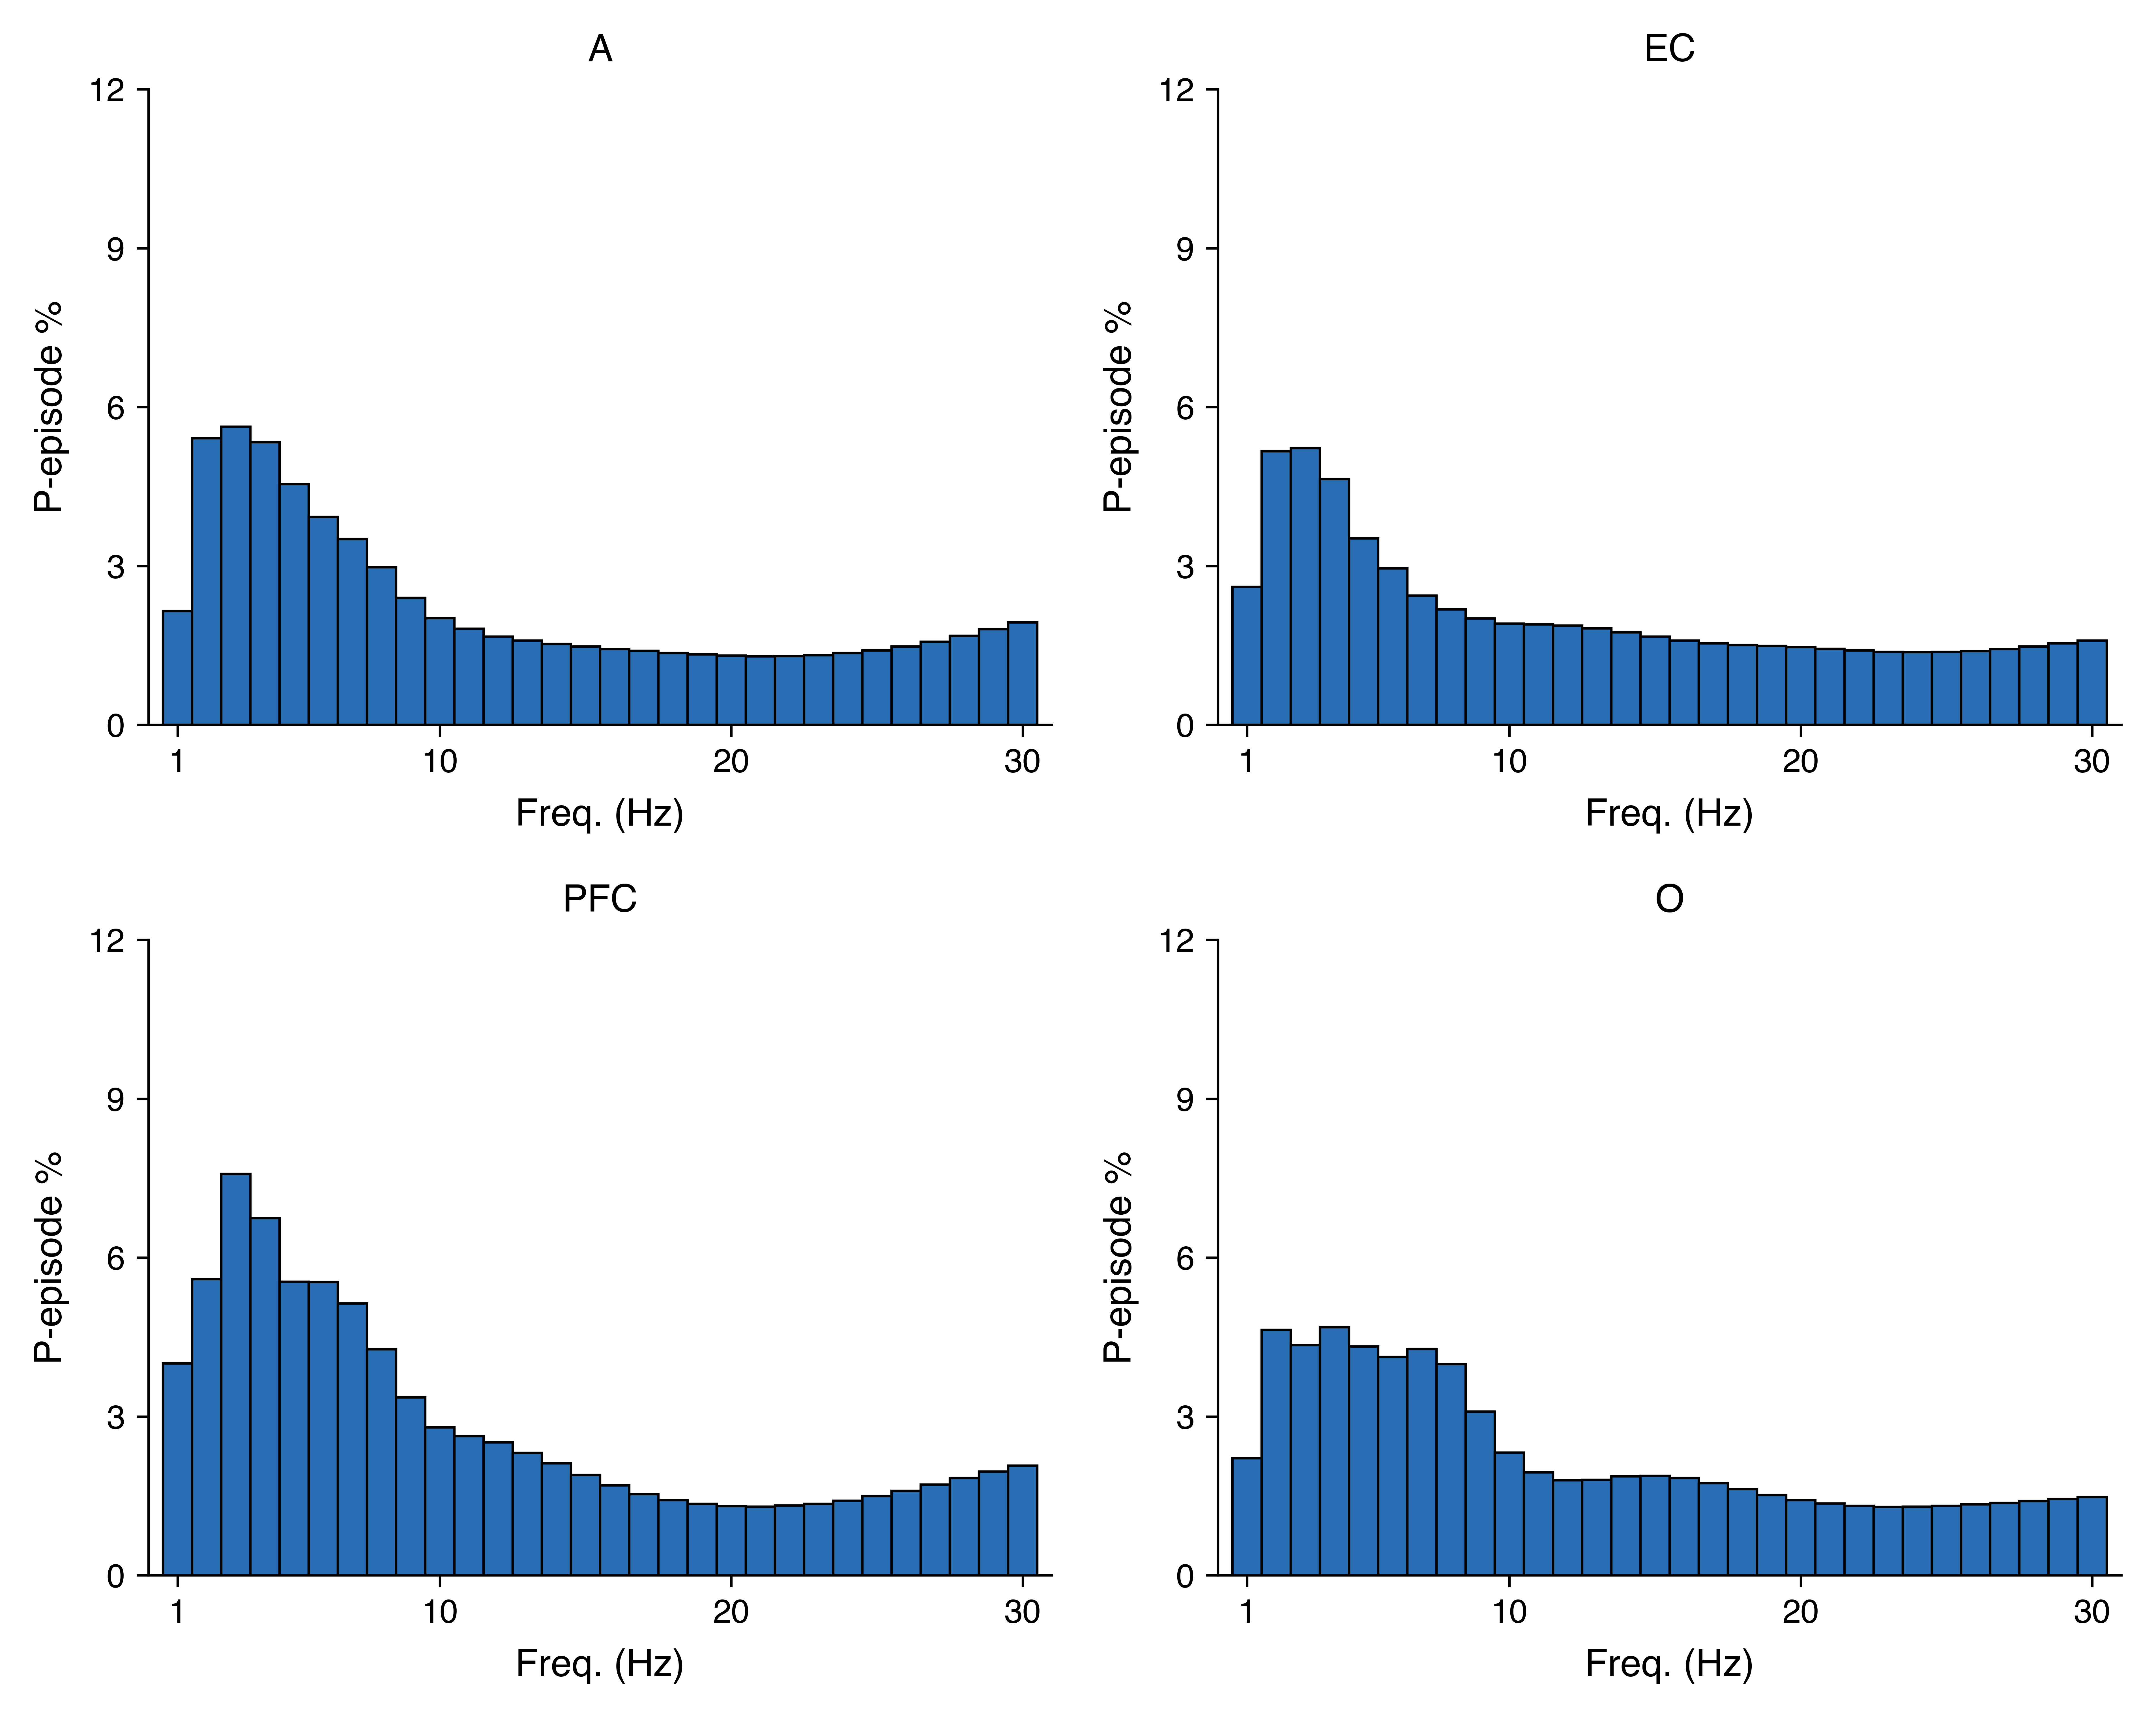

In [48]:
figsize = (colws[3], colws[3]*0.8)
dpi = 1200
savefig = False
overwrite = False
linewidth = 0.5
font = {'tick': 7, 'label': 8, 'fig': 8, 'annot': 7}
spine_lw = 0.5
ticklen = 2.5
tickwidth = 0.5
tickpad = 2.5
labelpad = 4
bar_width = 1
bar_color = colors['b']
bar_lw = 0.5
bar_ec = 'k'
freqs = np.arange(1, 51)
xvals = freqs
xlim = [0, 31]
xticks = [1, 10, 20, 30]
xticklabs = [1, 10, 20, 30]
xlabel = 'Freq. (Hz)'
ycol = 'n_peaks_norm'
density = False
ylim = [0, 12]
yticks = [0, 3, 6, 9, 12]
yticklabs = yticks

# -----------------------
plt.close()
fig, ax = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

rois = ['A', 'EC', 'PFC', 'O']
for iax, roi in enumerate(rois):
    _ax = ax[iax]
    _ax.bar(pep_pct_agg.columns, 100 * pep_pct_agg.loc[roi], width=bar_width, color=bar_color,
            lw=bar_lw, ec=bar_ec)
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_visible(True)
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], axis='both', which='major',
                    length=ticklen, width=tickwidth, pad=tickpad)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel(xlabel, fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticklabs)
    _ax.set_ylabel('P-episode %', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title(roi, fontsize=font['fig'])
    
fig.tight_layout()
fig.show()

# Oscillatory percentage in each game state

In [27]:
# Load all P-episode results.
data_dir = ['/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/delay',
            '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav',
            '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab']
n_rois = 8
save_output = 1
overwrite = 0
verbose = 1
freqs = np.arange(1, 31)

# -----------------------------
timer = Timer()

data_dir = np.atleast_1d(data_dir)
pep_pct = []
for _dir in data_dir:
    pep_pct.append(spectral_analysis.load_p_episode_pct(n_rois=n_rois,
                                                        data_dir=_dir,
                                                        save_output=save_output,
                                                        overwrite=overwrite,
                                                        verbose=verbose))
pep_pct = pd.concat(pep_pct).reset_index(drop=True)

# Format regions.
roi_map = spike_preproc.roi_mapping(n_rois)
drop_rois = ['MC', 'PC', 'TP']
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC']
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']

pep_pct['roi_gen'] = pep_pct['roi'].apply(lambda x: roi_map[x])

# Drop unwanted regions.
pep_pct = pep_pct.query("(roi_gen!='Other')").reset_index(drop=True)
pep_pct = pep_pct.query("(roi!={})".format(drop_rois)).reset_index(drop=True)

# Reformat regions.
pep_pct['roi_gen'] = pep_pct['roi_gen'].astype(str)
pep_pct.loc[pep_pct['roi_gen']=='CC', 'roi_gen'] = 'ACC'
pep_pct.loc[pep_pct['roi_gen']=='LTC', 'roi_gen'] = 'STG'
pep_pct['roi_gen'] = pep_pct['roi_gen'].astype(pd.CategoricalDtype(gen_rois, ordered=True))

pep_pct.insert(pep_pct.columns.tolist().index('roi_gen')+1, 'roi_gen2', '')
pep_pct.loc[np.isin(pep_pct['roi'], hpc_rois), 'roi_gen2'] = 'HPC'
pep_pct.loc[np.isin(pep_pct['roi'], mtl_rois), 'roi_gen2'] = 'MTL'
pep_pct.loc[~np.isin(pep_pct['roi'], hpc_rois + mtl_rois), 'roi_gen2'] = 'CTX'
pep_pct['roi_gen2'] = pep_pct['roi_gen2'].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

# Calculcate mean P-episode at each freq across sessions within each subject.
pep_pct_agg1 = pep_pct.groupby(['gameState', 'subj', 'roi_gen'], observed=True)[freqs].mean().reset_index()
pep_pct_agg2 = pep_pct.groupby(['gameState', 'subj', 'roi_gen2'], observed=True)[freqs].mean().reset_index()

print('pep_pct: {}'.format(pep_pct.shape))
print('pep_pct_agg1: {}'.format(pep_pct_agg1.shape))
print('pep_pct_agg2: {}'.format(pep_pct_agg2.shape))
print(timer)

pep_pct: (640, 37)
pep_pct_agg1: (268, 33)
pep_pct_agg2: (173, 33)
Ran in 1.1s


min = 1.27, max = 7.11
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/p_episode-goldmine-28subjs-17hpc_elecs.pdf


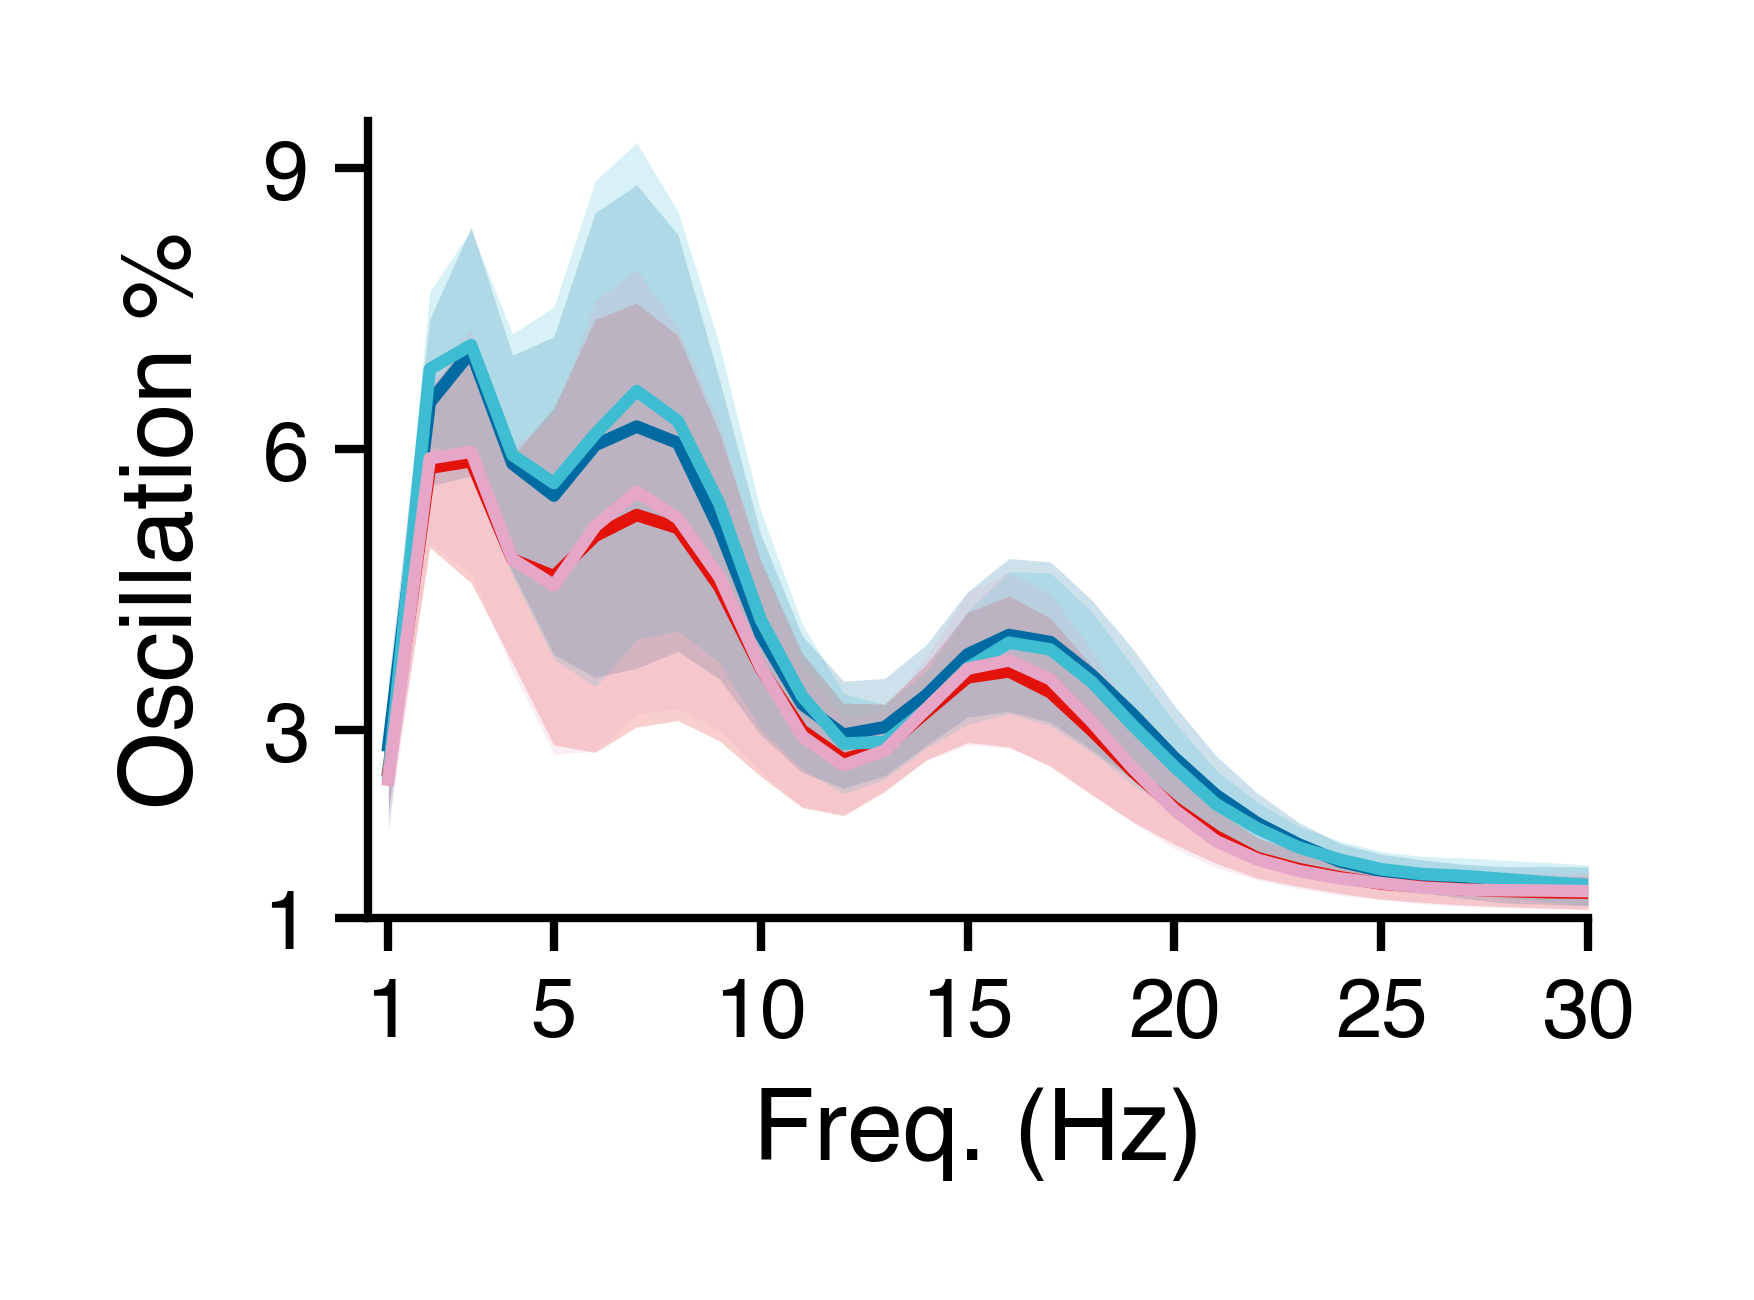

In [32]:
# Plot P-episode for each region, across electrodes for all subjects.
roi = 'HPC'
roi_col = 'roi_gen2'
expmt = 'goldmine'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
linecolor = {'Delay1': co['b'],
             'Delay2': co['c'],
             'Encoding': co['r'],
             'Retrieval': co['p2']}
savefig = 0
overwrite = 1
figsize = (colws[1]*0.8439, colws[1]*0.8439*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
linewidth = 0.75
spine_lw = 0.5
labelpad = 2
tickpad = 1.5
ticklen = 2
xlim = (0.5, 30)
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (1, 9.5)
yticks = [1, 3, 6, 9]
yticklabs = yticks
plot_err = 1
verbose = 0

# --------------------------------
# Get the data.
def nansem(x):
    return stats.sem(x, nan_policy='omit')
df = pep_pct.groupby(['gameState', 'subj', roi_col, 'hemroi'], observed=True)[freqs].mean().reset_index()
roi_count = (df
             .query("(gameState=={})".format(game_states))
             .drop_duplicates(['subj', 'hemroi'])
             .groupby(roi_col)
             .size())
means = pd.concat((df
                   .query("(gameState=={})".format(game_states))
                   .groupby(['gameState', roi_col])
                   .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                   df
                   .query("(gameState=={})".format(game_states))
                   .groupby(['gameState', roi_col])
                   .agg({freq: np.nanmean for freq in freqs})),
                  axis=1)
sems = pd.concat((df
                  .query("(gameState=={})".format(game_states))
                  .groupby(['gameState', roi_col])
                  .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                  df
                  .query("(gameState=={})".format(game_states))
                  .groupby(['gameState', roi_col])
                  .agg({freq: nansem for freq in freqs})),
                 axis=1)
print('min = {:.2f}, max = {:.2f}'
      .format(np.min(100 * means.iloc[[x[1]==roi for x in means.index], freqs].values),
              np.max(100 * means.iloc[[x[1]==roi for x in means.index], freqs].values)))

# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
for game_state in game_states:
    if plot_err:
        _ax.fill_between(xvals,
                         100 * (means.loc[(game_state, roi), freqs].values.astype(np.float64) +
                                sems.loc[(game_state, roi), freqs].values.astype(np.float64)),
                         100 * (means.loc[(game_state, roi), freqs].values.astype(np.float64) -
                                sems.loc[(game_state, roi), freqs].values.astype(np.float64)),
                         alpha=0.2, lw=0, color=linecolor[game_state])
    _ax.plot(xvals, 100 * means.loc[(game_state, roi), freqs].values,
             lw=linewidth, color=linecolor[game_state])

for spine in ['left', 'bottom']:
    _ax.spines[spine].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
if iax == 0:
    _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Oscillation %', fontsize=font['label'], labelpad=labelpad+1)
else:
    _ax.set_xlabel('')
    _ax.set_ylabel('')

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2',
                       'goldmine',
                       'p_episode-{}-{}subjs-{}{}_elecs.pdf'
                       .format(expmt,
                               pow_pct_agg2['subj'].unique().size,
                               roi_count[roi],
                               roi.lower()))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
#         fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

min = -1.15, max = -0.07
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/p_episode-goldmine_nav_minus_delay-28subjs-17hpc_elecs.pdf


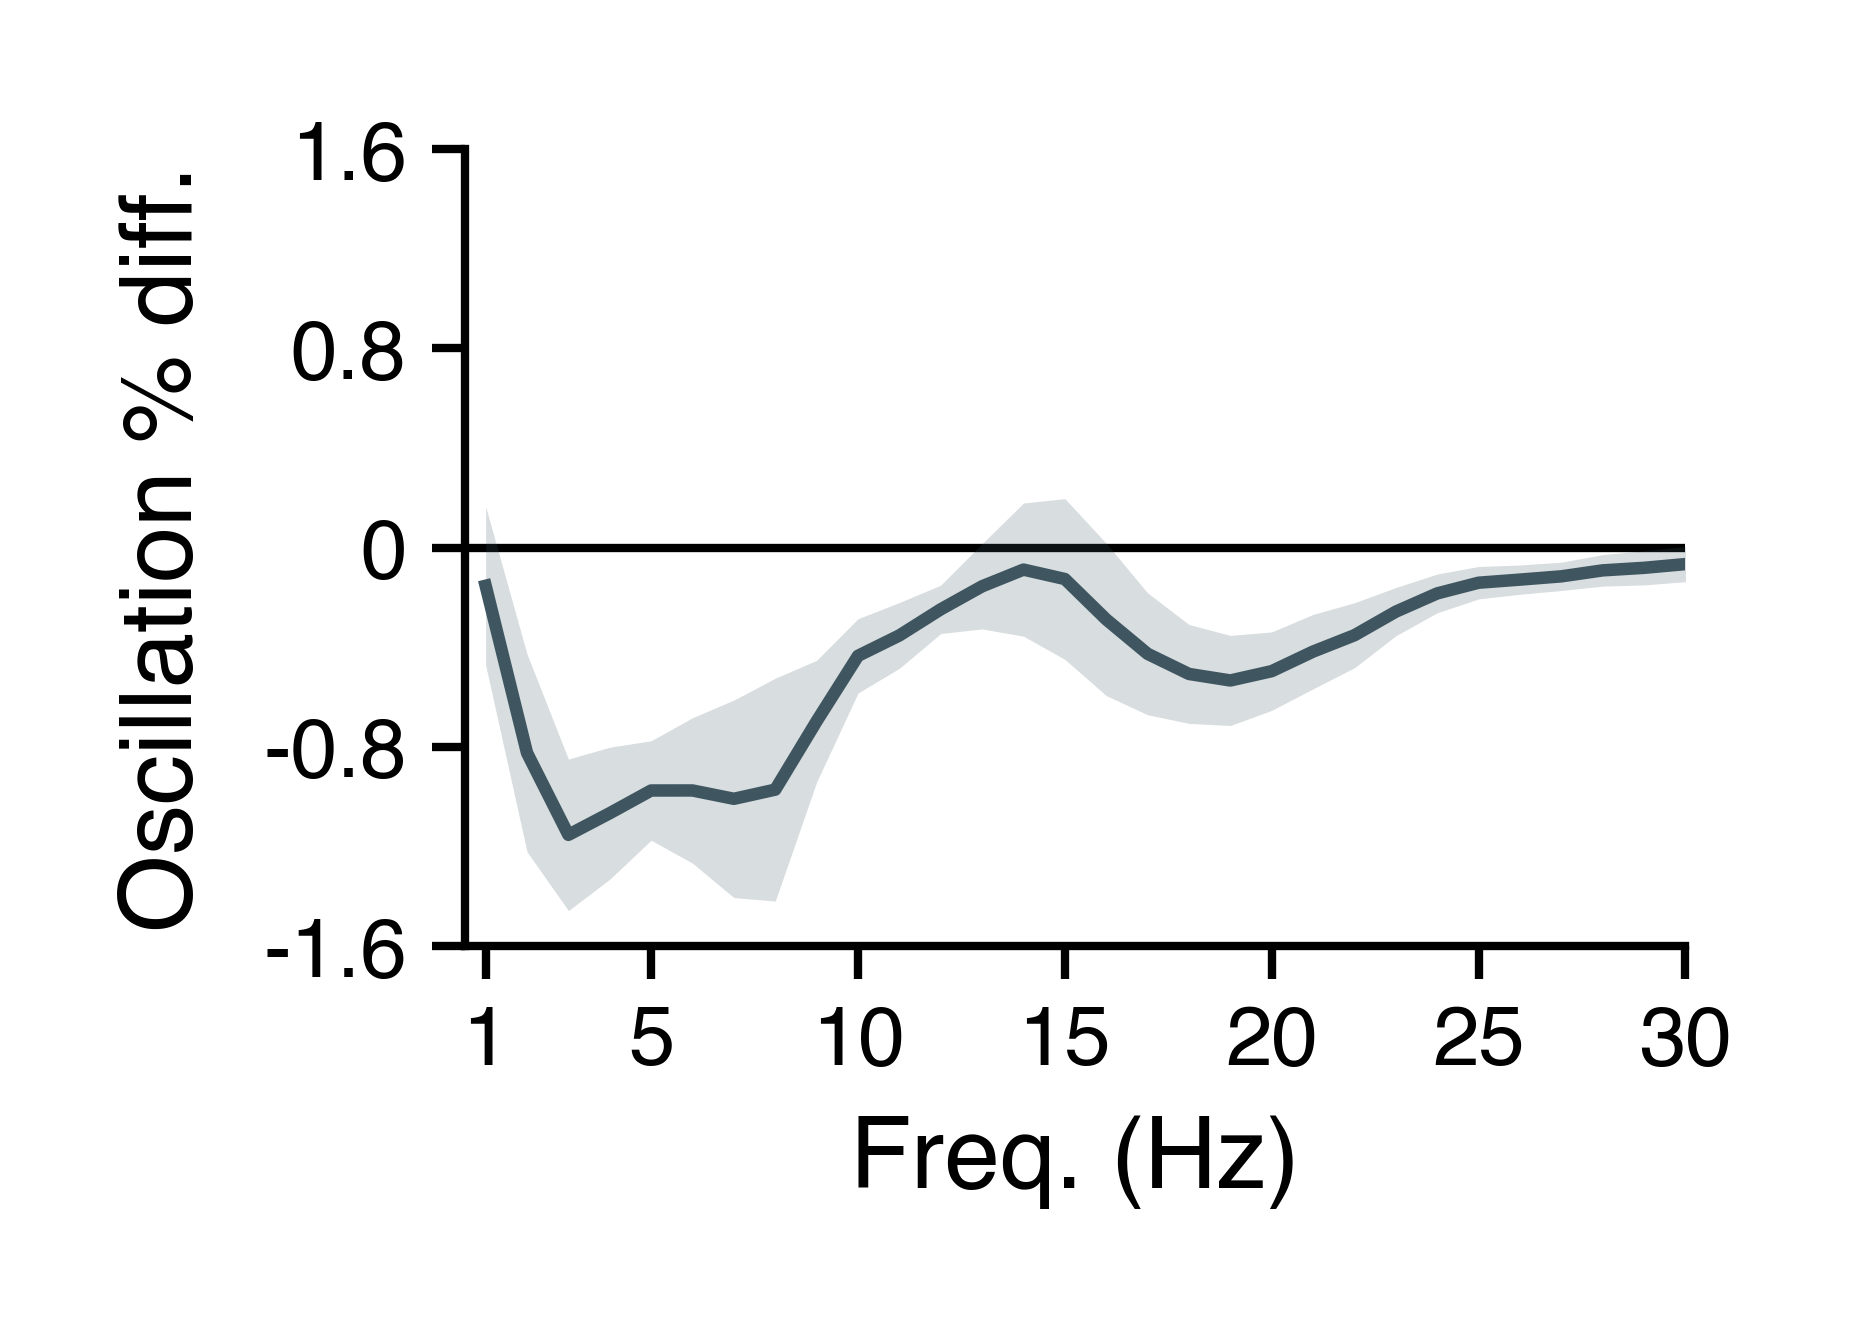

In [36]:
# Plot P-episode for each region, across electrodes for all subjects.
roi = 'HPC'
roi_col = 'roi_gen2'
expmt = 'goldmine'
savefig = 0
overwrite = 1
figsize = (colws[1]*0.8439, colws[1]*0.8439*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
linewidth = 0.75
spine_lw = 0.5
labelpad = 2
tickpad = 1.5
ticklen = 2
xlim = (0.5, 30)
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-1.6, 1.6)
yticks = [-1.6, -0.8, 0, 0.8, 1.6]
yticklabs = yticks
linecolor = colors['x4']
plot_hline = 1
hline = 0
hline_color = 'k'
plot_err = 1
verbose = 0

# --------------------------------
# Get the data.
def nansem(x):
    return stats.sem(x, nan_policy='omit')

df1 = (pep_pct
       .query("(gameState=={})".format(['Encoding', 'Retrieval']))
       .groupby(['subj', roi_col, 'hemroi'], observed=True)
       [freqs].mean())
df1.columns = pd.MultiIndex.from_tuples([('nav', freq) for freq in df1.columns],
                                        names=['gameState', 'freq'])
df2 = (pep_pct
       .query("(gameState=={})".format(['Delay1', 'Delay2']))
       .groupby(['subj', roi_col, 'hemroi'], observed=True)
       [freqs].mean())
df2.columns = pd.MultiIndex.from_tuples([('delay', freq) for freq in df2.columns],
                                        names=['gameState', 'freq'])
df = pd.concat((df1, df2), axis=1)
df = df.loc[:, 'nav'] - df.loc[:, 'delay']
roi_count = (df
             .reset_index()
             .drop_duplicates(['subj', 'hemroi'])
             .groupby(roi_col)
             .size())
means = pd.concat((df
                   .reset_index()
                   .groupby([roi_col])
                   .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                   df
                   .reset_index()
                   .groupby([roi_col])
                   .agg({freq: np.nanmean for freq in freqs})),
                  axis=1)
sems = pd.concat((df
                  .reset_index()
                  .groupby([roi_col])
                  .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                  df
                  .reset_index()
                  .groupby([roi_col])
                  .agg({freq: nansem for freq in freqs})),
                 axis=1)
print('min = {:.2f}, max = {:.2f}'
      .format(np.min(100 * means.loc[roi, freqs].values),
              np.max(100 * means.loc[roi, freqs].values)))

# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
if plot_hline:
    _ax.axhline(hline, lw=spine_lw, color=hline_color, zorder=0)
if plot_err:
    _ax.fill_between(xvals,
                     100 * (means.loc[roi, freqs].values.astype(np.float64) +
                            sems.loc[roi, freqs].values.astype(np.float64)),
                     100 * (means.loc[roi, freqs].values.astype(np.float64) -
                            sems.loc[roi, freqs].values.astype(np.float64)),
                     alpha=0.2, lw=0, color=linecolor, zorder=1)
_ax.plot(xvals, 100 * means.loc[roi, freqs].values,
         lw=linewidth, color=linecolor, zorder=2)

for spine in ['left', 'bottom']:
    _ax.spines[spine].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
if iax == 0:
    _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Oscillation % diff.', fontsize=font['label'], labelpad=labelpad+1)
else:
    _ax.set_xlabel('')
    _ax.set_ylabel('')

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2',
                       'goldmine',
                       'p_episode-{}-{}subjs-{}{}_elecs.pdf'
                       .format(expmt + '_nav_minus_delay',
                               pow_pct_agg2['subj'].unique().size,
                               roi_count[roi],
                               roi.lower()))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
#         fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

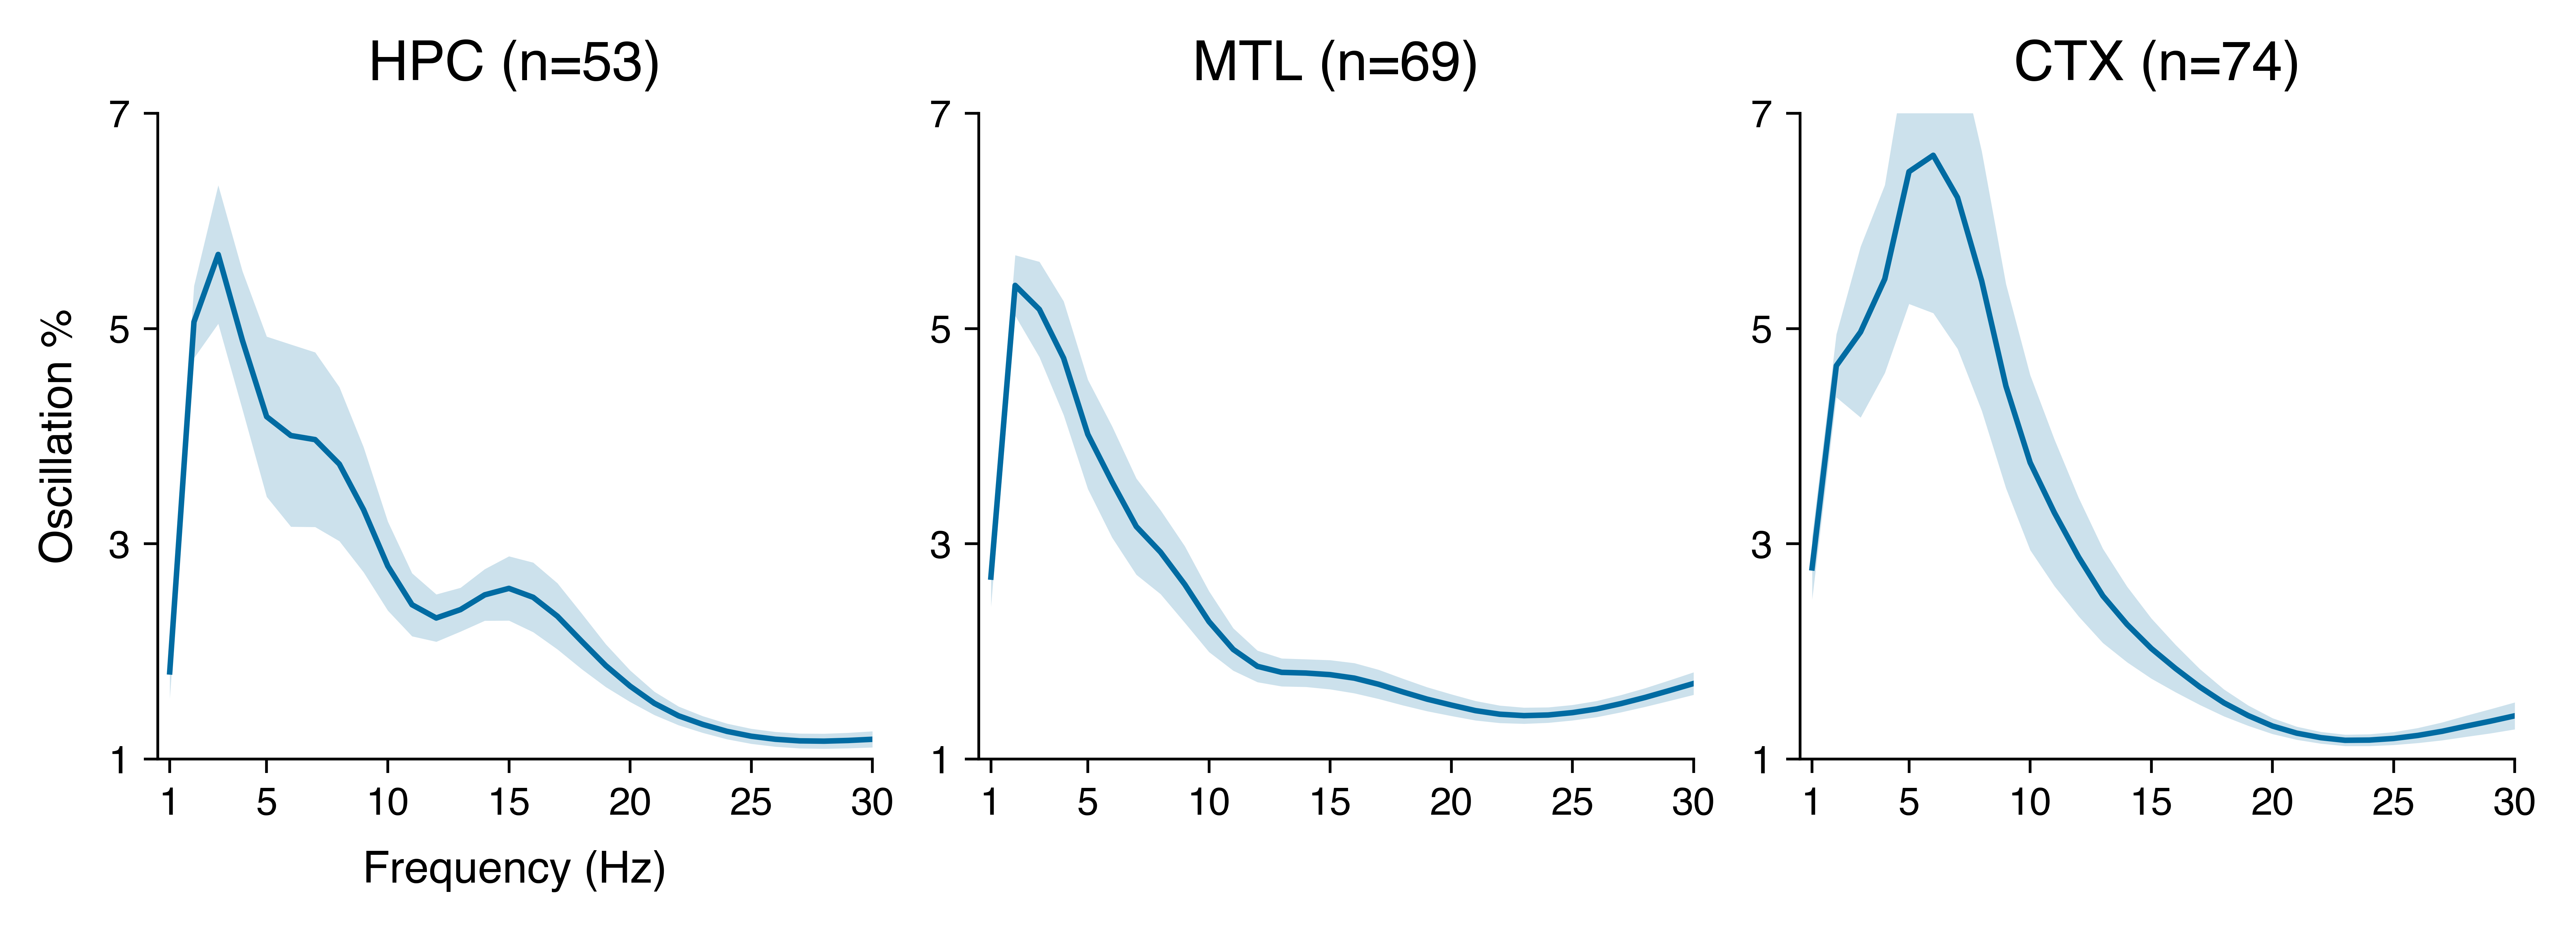

In [331]:
# Plot P-episode for each region, across electrodes for all subjects.
roi_col = 'roi_gen2'
rois = ['HPC', 'MTL', 'CTX']
expmt = 'ycab_goldmine_nav'
game_states = ['YCab', 'Encoding', 'Retrieval']
linecolor = co['b']
savefig = 1
overwrite = 0
figsize = (colws[3], colws[3]*0.36)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
linewidth = 1
spine_lw = 0.5
labelpad = 5
tickpad = 2.5
ticklen = 2.5
xlim = (0.5, 30)
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (1, 7)
yticks = [1, 3, 5, 7]
yticklabs = yticks
verbose = 0

# --------------------------------
# Get the data.
def nansem(x):
    return stats.sem(x, nan_policy='omit')
df = (pep_pct
      .query("(gameState=={})".format(game_states))
#       .groupby(['subj', roi_col], observed=True)
      .groupby(['subj', roi_col, 'hemroi'], observed=True)
      [freqs].mean()
      .reset_index())
roi_count = (df
#              .drop_duplicates(['subj', roi_col])
             .drop_duplicates(['subj', 'hemroi'])
             .groupby(roi_col)
             .size())
means = pd.concat((df    
                   .groupby([roi_col])
                   .agg({'subj': lambda x: np.unique(x).size}),
                   df
                   .groupby([roi_col])
                   .agg({freq: np.nanmean for freq in freqs})),
                  axis=1)
sems = pd.concat((df
                  .groupby([roi_col])
                  .agg({'subj': lambda x: np.unique(x).size}),
                  df
                  .groupby([roi_col])
                  .agg({freq: nansem for freq in freqs})),
                 axis=1)

# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, roi in enumerate(rois):
    _ax = ax[iax]
    _ax.fill_between(xvals,
                     100 * (means.loc[roi, freqs].values + sems.loc[roi, freqs].values),
                     100 * (means.loc[roi, freqs].values - sems.loc[roi, freqs].values),
                     alpha=0.2, lw=0, color=linecolor, zorder=0)
    _ax.plot(xvals, 100 * means.loc[roi, freqs].values,
             lw=linewidth, color=linecolor, zorder=1)
    
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    _ax.set_title('{} (n={})'.format(roi, roi_count[roi]), fontsize=font['fig'])
    if iax == 0:
        _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('Oscillation %', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.set_xlabel('')
        _ax.set_ylabel('')
        
fig.tight_layout()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2', 
                       'p_episode-{}-{}subjs-{}hpc_{}mtl_{}ctx_elecs.pdf'
                       .format(expmt,
                               pep_pct_agg2['subj'].unique().size,
                               roi_count['HPC'],
                               roi_count['MTL'],
                               roi_count['CTX']))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
#         fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

# Power in each game state

In [3]:
# Load all P-episode results.
data_dir = ['/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/delay',
            '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav',
            '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab']
n_rois = 8
save_output = 1
overwrite = 0
verbose = 1
freqs = np.arange(1, 31)

# -----------------------------
timer = Timer()

data_dir = np.atleast_1d(data_dir)
pow_pct = []
for _dir in data_dir:
    pow_pct.append(spectral_analysis.load_pow_pct(n_rois=n_rois,
                                                  data_dir=_dir,
                                                  save_output=save_output,
                                                  overwrite=overwrite,
                                                  verbose=verbose))
pow_pct = pd.concat(pow_pct).reset_index(drop=True)

# Format regions.
roi_map = spike_preproc.roi_mapping(n_rois)
drop_rois = ['MC', 'PC', 'TP']
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC']
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']

pow_pct['roi_gen'] = pow_pct['roi'].apply(lambda x: roi_map[x])

# Drop unwanted regions.
pow_pct = pow_pct.query("(roi_gen!='Other')").reset_index(drop=True)
pow_pct = pow_pct.query("(roi!={})".format(drop_rois)).reset_index(drop=True)

# Reformat regions.
pow_pct['roi_gen'] = pow_pct['roi_gen'].astype(str)
pow_pct.loc[pow_pct['roi_gen']=='CC', 'roi_gen'] = 'ACC'
pow_pct.loc[pow_pct['roi_gen']=='LTC', 'roi_gen'] = 'STG'
pow_pct['roi_gen'] = pow_pct['roi_gen'].astype(pd.CategoricalDtype(gen_rois, ordered=True))

pow_pct.insert(pow_pct.columns.tolist().index('roi_gen')+1, 'roi_gen2', '')
pow_pct.loc[np.isin(pow_pct['roi'], hpc_rois), 'roi_gen2'] = 'HPC'
pow_pct.loc[np.isin(pow_pct['roi'], mtl_rois), 'roi_gen2'] = 'MTL'
pow_pct.loc[~np.isin(pow_pct['roi'], hpc_rois + mtl_rois), 'roi_gen2'] = 'CTX'
pow_pct['roi_gen2'] = pow_pct['roi_gen2'].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

# Calculcate mean P-episode at each freq across sessions within each subject.
pow_pct_agg1 = pow_pct.groupby(['gameState', 'subj', 'roi_gen'], observed=True)[freqs].mean().reset_index()
pow_pct_agg2 = pow_pct.groupby(['gameState', 'subj', 'roi_gen2'], observed=True)[freqs].mean().reset_index()

print('pow_pct: {}'.format(pow_pct.shape))
print('pow_pct_agg1: {}'.format(pow_pct_agg1.shape))
print('pow_pct_agg2: {}'.format(pow_pct_agg2.shape))
print(timer)

pow_pct: (640, 37)
pow_pct_agg1: (268, 33)
pow_pct_agg2: (173, 33)
Ran in 0.7s


In [18]:
colws[1]*0.8439

1.3123640802

min = 4.98, max = 7.83
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/power-goldmine-28subjs-17hpc_elecs.pdf


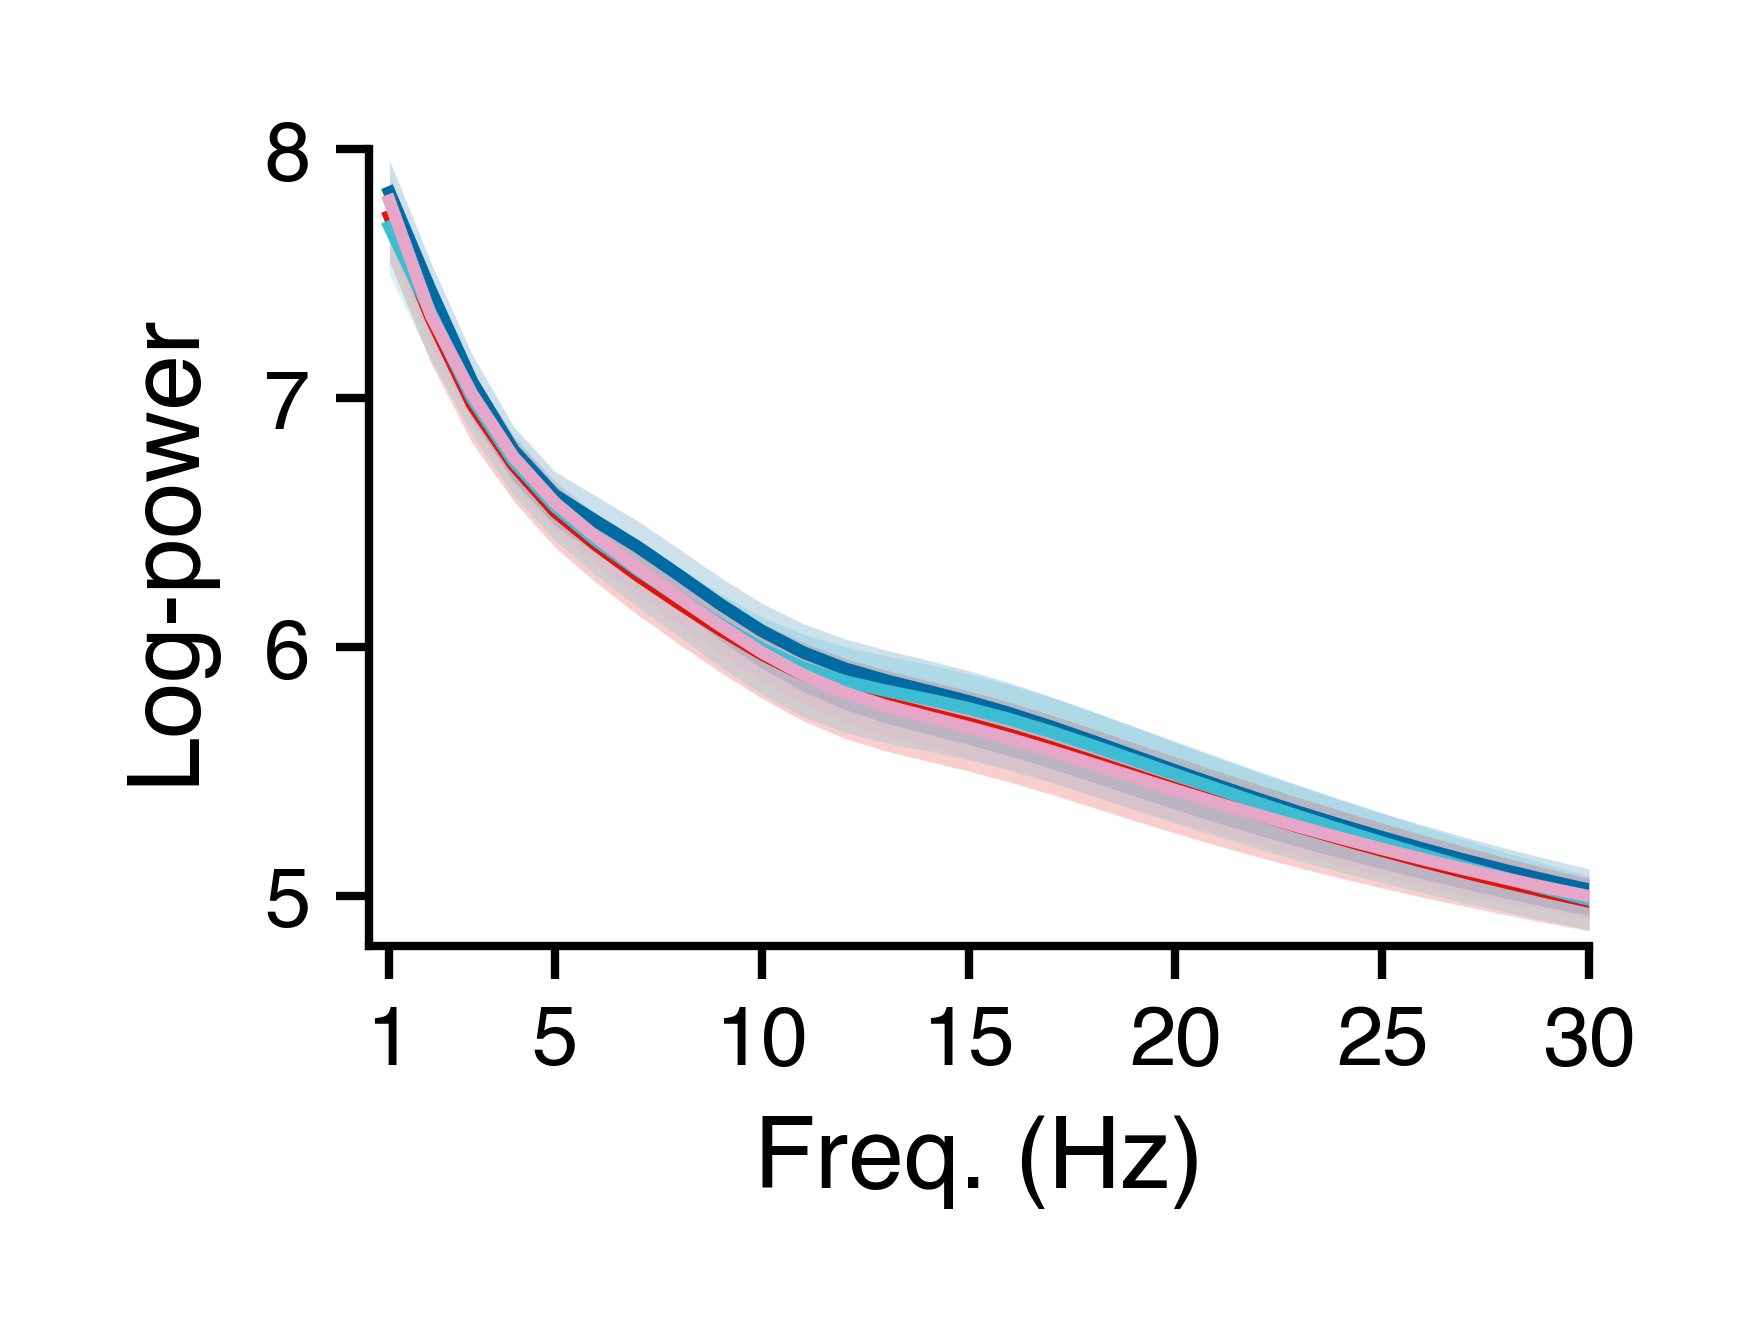

In [22]:
# Plot power in each region, across electrodes for all subjects.
roi = 'HPC'
roi_col = 'roi_gen2'
# df = pow_pct_agg2
df = pow_pct.groupby(['gameState', 'subj', roi_col, 'hemroi'], observed=True)[freqs].mean().reset_index()
expmt = 'goldmine'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
roi_count = (df
             .query("(gameState=={})".format(game_states))
             .drop_duplicates(['subj', 'hemroi'])
             .groupby(roi_col)
             .size())
linecolor = {'Delay1': co['b'],
             'Delay2': co['c'],
             'Encoding': co['r'],
             'Retrieval': co['p2']}
savefig = 0
overwrite = 1
figsize = (colws[1]*0.8439, colws[1]*0.8439*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
linewidth = 0.75
spine_lw = 0.5
labelpad = 2
tickpad = 1.5
ticklen = 2
xlim = (0.5, 30)
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (4.8, 8) #(4, 8.5)
yticks = [5, 6, 7, 8] #[4, 5, 6, 7, 8]
yticklabs = yticks
plot_err = 1
verbose = 0

# --------------------------------
# Get the data.
def nansem(x):
    return stats.sem(x, nan_policy='omit')

means = pd.concat((df
                   .query("(gameState=={})".format(game_states))
                   .groupby(['gameState', roi_col])
                   .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                   df
                   .query("(gameState=={})".format(game_states))
                   .groupby(['gameState', roi_col])
                   .agg({freq: np.nanmean for freq in freqs})),
                  axis=1)
sems = pd.concat((df
                  .query("(gameState=={})".format(game_states))
                  .groupby(['gameState', roi_col])
                  .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                  df
                  .query("(gameState=={})".format(game_states))
                  .groupby(['gameState', roi_col])
                  .agg({freq: nansem for freq in freqs})),
                 axis=1)
print('min = {:.2f}, max = {:.2f}'
      .format(np.min(np.log10(means.iloc[[x[1]==roi for x in means.index], freqs].values)),
              np.max(np.log10(means.iloc[[x[1]==roi for x in means.index], freqs].values))))

# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
for game_state in game_states:
    if plot_err:
        _ax.fill_between(xvals,
                         np.log10(means.loc[(game_state, roi), freqs].values.astype(np.float64) +
                                  sems.loc[(game_state, roi), freqs].values.astype(np.float64)),
                         np.log10(means.loc[(game_state, roi), freqs].values.astype(np.float64) -
                                  sems.loc[(game_state, roi), freqs].values.astype(np.float64)),
                         alpha=0.2, lw=0, color=linecolor[game_state])
    _ax.plot(xvals, np.log10(means.loc[(game_state, roi), freqs].values.astype(np.float64)),
             lw=linewidth, color=linecolor[game_state])

for spine in ['left', 'bottom']:
    _ax.spines[spine].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
if iax == 0:
    _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Log-power', fontsize=font['label'], labelpad=labelpad+1)
else:
    _ax.set_xlabel('')
    _ax.set_ylabel('')

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2',
                       'goldmine',
                       'power-{}-{}subjs-{}{}_elecs.pdf'
                       .format(expmt,
                               pow_pct_agg2['subj'].unique().size,
                               roi_count[roi],
                               roi.lower()))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
#         fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
    
fig.show()

In [300]:
df1 = (pow_pct
       .query("(gameState=={})".format(['Encoding', 'Retrieval']))
       .groupby(['subj', roi_col, 'hemroi'], observed=True)
       [freqs].mean())
df1.columns = pd.MultiIndex.from_tuples([('nav', freq) for freq in df1.columns],
                                        names=['gameState', 'freq'])
df2 = (pow_pct
       .query("(gameState=={})".format(['Delay1', 'Delay2']))
       .groupby(['subj', roi_col, 'hemroi'], observed=True)
       [freqs].mean())
df2.columns = pd.MultiIndex.from_tuples([('delay', freq) for freq in df2.columns],
                                        names=['gameState', 'freq'])
df = pd.concat((df1, df2), axis=1)
df.loc[:, :] = np.log10(df.values.astype(np.float64))

In [309]:
(means.loc[roi, freqs].values + sems.loc[roi, freqs].values).dtype

dtype('O')

min = -0.04, max = 0.01
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/power-goldmine_nav_minus_delay-28subjs-17hpc_elecs.pdf


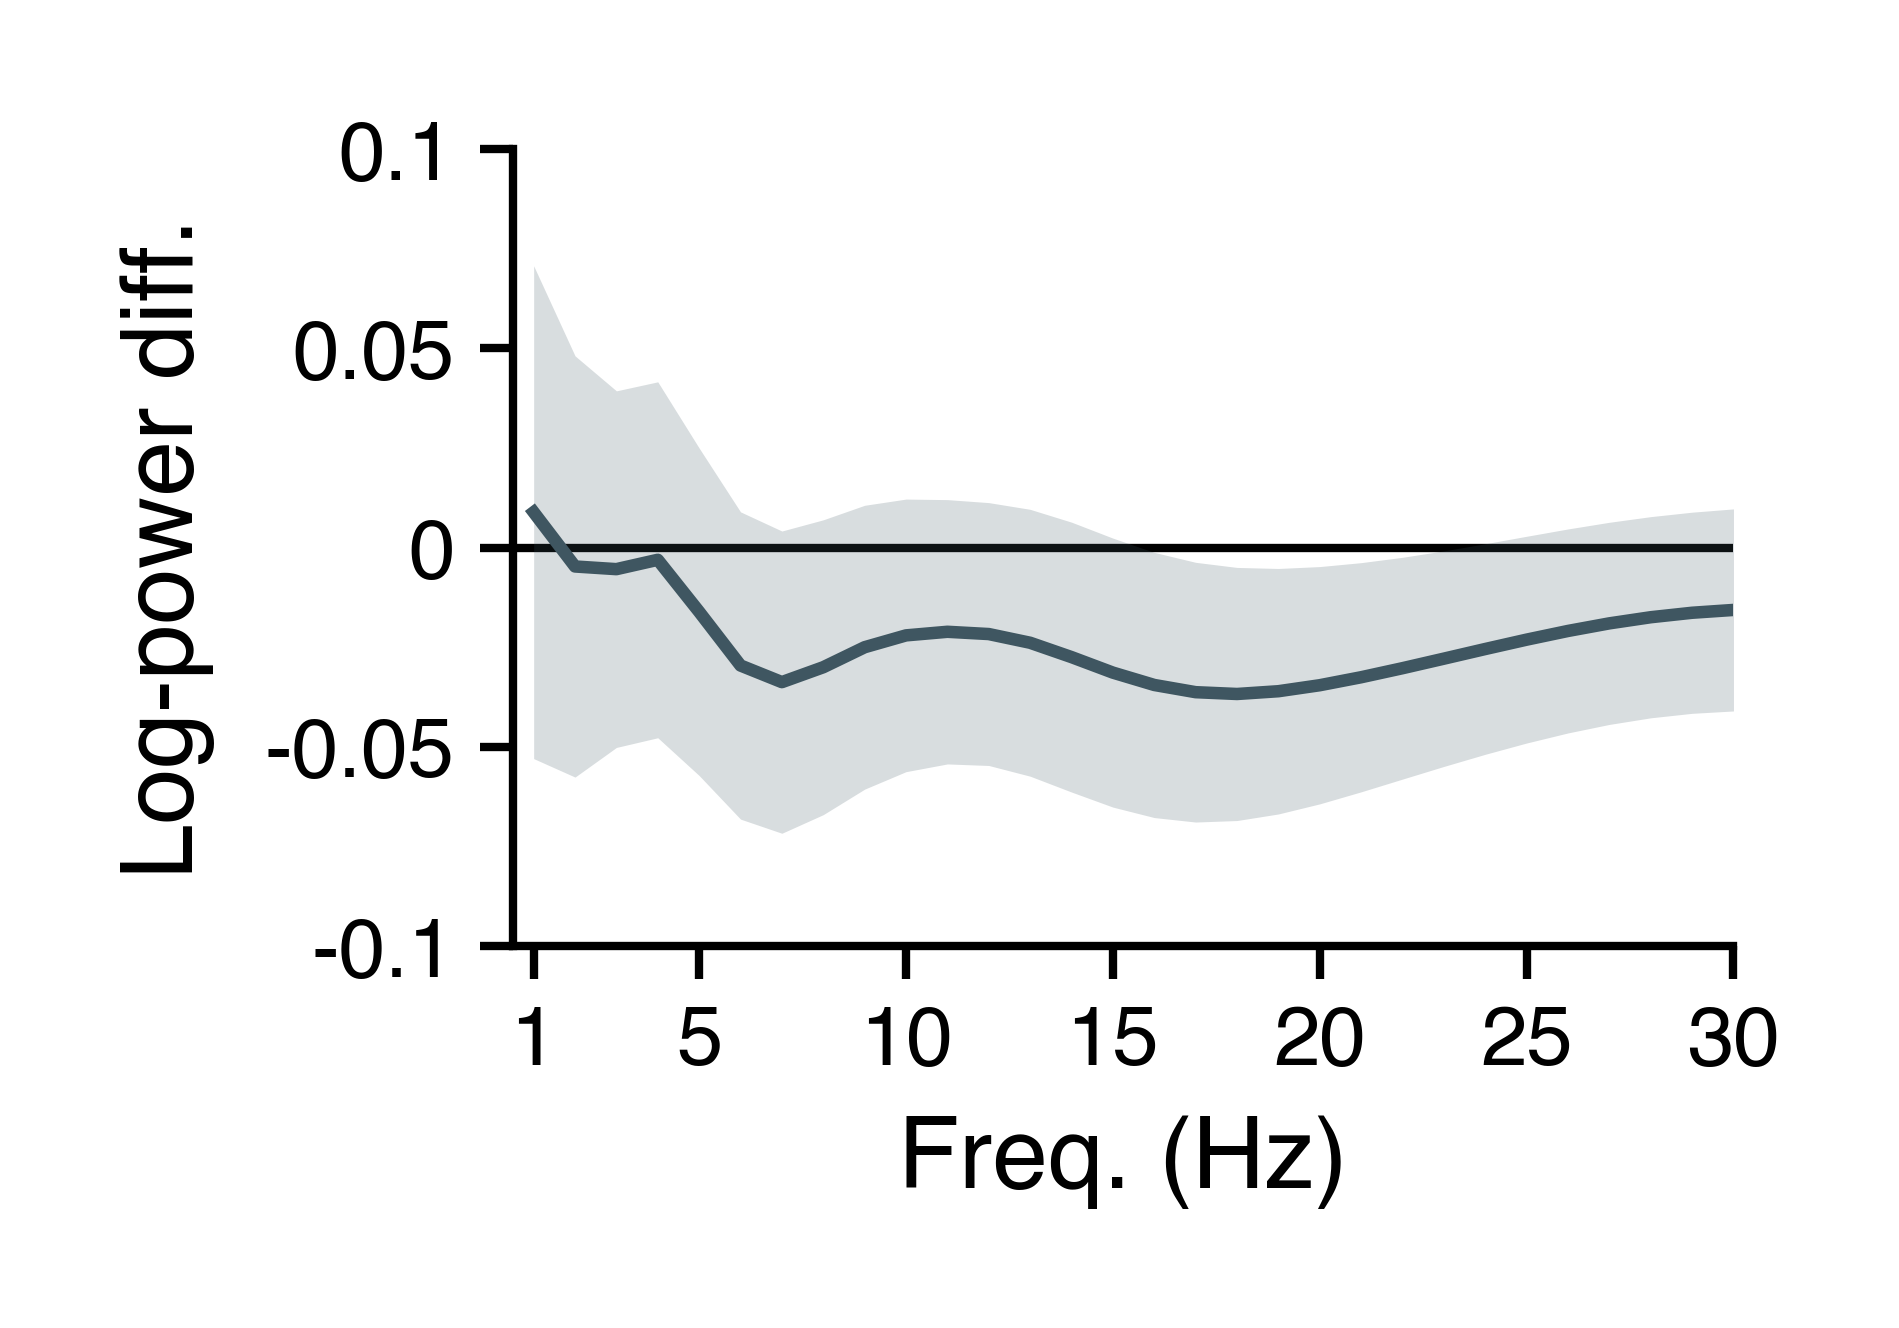

In [26]:
# Plot P-episode for each region, across electrodes for all subjects.
roi = 'HPC'
roi_col = 'roi_gen2'
expmt = 'goldmine'
savefig = 0
overwrite = 1
figsize = (colws[1]*0.8439, colws[1]*0.8439*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
linewidth = 0.75
spine_lw = 0.5
labelpad = 2
tickpad = 1.5
ticklen = 2
xlim = (0.5, 30)
xvals = freqs
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-0.1, 0.1) #(-1.5, 1.5)
yticks = [-0.1, -0.05, 0, 0.05, 0.1] #[-1.5, 0, 1.5]
yticklabs = yticks
linecolor = colors['x4']
plot_hline = 1
hline = 0
hline_color = 'k'
plot_err = 1
verbose = 0

# --------------------------------
# Get the data.
def nansem(x):
    return stats.sem(x, nan_policy='omit')

df1 = (pow_pct
       .query("(gameState=={})".format(['Encoding', 'Retrieval']))
       .groupby(['subj', roi_col, 'hemroi'], observed=True)
       [freqs].mean())
df1.columns = pd.MultiIndex.from_tuples([('nav', freq) for freq in df1.columns],
                                        names=['gameState', 'freq'])
df2 = (pow_pct
       .query("(gameState=={})".format(['Delay1', 'Delay2']))
       .groupby(['subj', roi_col, 'hemroi'], observed=True)
       [freqs].mean())
df2.columns = pd.MultiIndex.from_tuples([('delay', freq) for freq in df2.columns],
                                        names=['gameState', 'freq'])
df = pd.concat((df1, df2), axis=1)
df.loc[:, :] = np.log10(df.values.astype(np.float64))
df = df.loc[:, 'nav'] - df.loc[:, 'delay']
roi_count = (df
             .reset_index()
             .drop_duplicates(['subj', 'hemroi'])
             .groupby(roi_col)
             .size())
means = pd.concat((df
                   .reset_index()
                   .groupby([roi_col])
                   .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                   df
                   .reset_index()
                   .groupby([roi_col])
                   .agg({freq: np.nanmean for freq in freqs})),
                  axis=1)
sems = pd.concat((df
                  .reset_index()
                  .groupby([roi_col])
                  .agg({'subj': lambda x: (np.unique(x).size, len(x))}),
                  df
                  .reset_index()
                  .groupby([roi_col])
                  .agg({freq: nansem for freq in freqs})),
                 axis=1)
print('min = {:.2f}, max = {:.2f}'
      .format(np.min(means.loc[roi, freqs].values.astype(np.float64)),
              np.max(means.loc[roi, freqs].values.astype(np.float64))))

# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
if plot_hline:
    _ax.axhline(hline, lw=spine_lw, color=hline_color, zorder=0)
if plot_err:
    _ax.fill_between(xvals,
                     means.loc[roi, freqs].values.astype(np.float64) + sems.loc[roi, freqs].values.astype(np.float64),
                     means.loc[roi, freqs].values.astype(np.float64) - sems.loc[roi, freqs].values.astype(np.float64),
                     alpha=0.2, lw=0, color=linecolor, zorder=1)
_ax.plot(xvals, means.loc[roi, freqs].values.astype(np.float64),
         lw=linewidth, color=linecolor, zorder=2)

for spine in ['left', 'bottom']:
    _ax.spines[spine].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
if iax == 0:
    _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Log-power diff.', fontsize=font['label'], labelpad=labelpad+1)
else:
    _ax.set_xlabel('')
    _ax.set_ylabel('')

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2',
                       'goldmine',
                       'power-{}-{}subjs-{}{}_elecs.pdf'
                       .format(expmt + '_nav_minus_delay',
                               pow_pct_agg2['subj'].unique().size,
                               roi_count[roi],
                               roi.lower()))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
#         fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [36]:
from time_cells import events_proc

In [61]:
sess_durs = np.array([(events_proc.load_events(sessions[ii], verbose=False).events['time'].iloc[-1] -
                       events_proc.load_events(sessions[ii], verbose=False).events['time'].iloc[0])
                      * 1e-3 * (1/60)
                      for ii in range(len(sessions))])
print(np.mean(sess_durs))

62.94509166666668
